In [1]:
import os
import pandas as pd
import numpy as np
from typing import Dict, List
import importlib
from pathlib import Path
import matplotlib.pyplot as plt
import MeCab
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold
import os
import yaml
os.environ["WANDB_NOTEBOOK_NAME"] = (
    "/home/masa1357/Dockerdata/gitfile/Tree-Model/src/sweep.ipynb"
)

In [2]:
# INFO: import local libraries
import python.data_manager as dm
import python.Mecab_processing as mp
import python.util as util

In [3]:
BASE_PATH = Path.cwd().parent
DATA_PATH = BASE_PATH / "data"
MODEL_PATH = BASE_PATH / "model"
print(f"BASE_PATH: {BASE_PATH}")
print(f"DATA_PATH: {DATA_PATH}")
print(f"MODEL_PATH: {MODEL_PATH}")

BASE_PATH: /home/masa1357/Dockerdata/gitfile/Tree-Model
DATA_PATH: /home/masa1357/Dockerdata/gitfile/Tree-Model/data
MODEL_PATH: /home/masa1357/Dockerdata/gitfile/Tree-Model/model


In [4]:
importlib.reload(util)
# ? logger読み込み
name = "15-Ensemble"
logger = util.set_logger()
# ? seed値固定
seed = 42
util.set_seed(seed)

2024-08-15 02:41:50,560 : python.util : INFO : 34 : Test_message


In [5]:
# ? データ読み込み
# import python.data_manager as dm

importlib.reload(dm)
# argsでloggerの名前を送る
args: Dict[str, object] = {
    "logger": logger,
    "DATA_PATH": DATA_PATH,
    "key": "userid",
    "text": "answer_content",
    "label": "grade",
    "mode": "train-valid",
    "split_rate": [0.8, 0.2, 0],
    "seed": seed,
}

with util.timer("load data"):
    dp = dm.DataProcessing(args)
    train, valid = dp()

2024-08-15 02:41:50,568 : python.util.python.data_manager : INFO : 16 : setup Child logger : python.data_manager
2024-08-15 02:41:50,568 : python.util.python.data_manager : INFO : 65 : Read /home/masa1357/Dockerdata/gitfile/Tree-Model/data/Reflection *.csv data...
2024-08-15 02:41:50,570 : python.util.python.data_manager : INFO : 67 : Found files: [PosixPath('/home/masa1357/Dockerdata/gitfile/Tree-Model/data/Reflection/Course_C-2021-2_Reflection.csv'), PosixPath('/home/masa1357/Dockerdata/gitfile/Tree-Model/data/Reflection/Course_C-2022-1_Reflection.csv'), PosixPath('/home/masa1357/Dockerdata/gitfile/Tree-Model/data/Reflection/Course_C-2021-1_Reflection.csv')]
2024-08-15 02:41:50,648 : python.util.python.data_manager : INFO : 74 : Total rows: 28275
2024-08-15 02:41:50,649 : python.util.python.data_manager : INFO : 65 : Read /home/masa1357/Dockerdata/gitfile/Tree-Model/data/Grade *.csv data...
2024-08-15 02:41:50,650 : python.util.python.data_manager : INFO : 67 : Found files: [PosixPat

[load data] start
[load data] done in 0.71 s


In [6]:
train

,userid,grade,text,course_number,question_number,label
0,C-2022-1_U72,C,情報科学の時間で学習する内容や授業で使う教材システム評価方法の説明,01,1,2
1,C-2021-1_U70,D,授業の説明情報伝達の歴史を大まかに学んだ,01,1,3
2,C-2021-2_U103,B,情報教育が軽視されているが今の世の中で情報について知ることは必須である情報は伝送しやすい形に...,01,1,1
3,C-2021-2_U139,B,情報科学の発展は目覚ましくインタネットを使うことで様々な情報を２進数に変化し扱うことができる...,01,1,1
4,C-2022-1_U7,C,情報科学についてを知ることができました,01,1,2
...,...,...,...,...,...,...
22415,C-2022-1_U89,B,今日は60分間テストの後アンケトに答えて授業が終わるという日でしたので新たに知識を発見すると...,15,5,1
22421,C-2021-2_U46,D,情報量の計算はやりかたを覚えていなかったため解けなかった\r\n他の問題はそれなりに覚えてい...,15,5,3
22422,C-2021-1_U2,A,記述問題が難しかったが計算や選択問題は比較的できたと思う,15,5,0
22423,C-2021-1_U75,B,テストの時間が足りなかったのが残念だった情報科学の授業を通してコンピュタに関わる仕組みの基本...,15,5,1


### 簡単な可視化
- 成績ごとの単語数分布
- 質問ごとの単語数分布
- 講義回数ごとの単語数分布
  

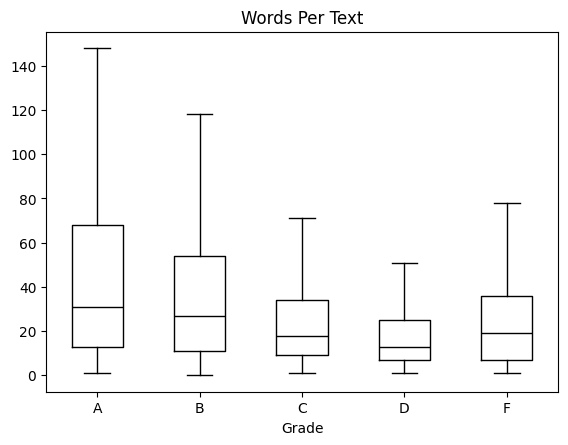

In [7]:
# INFO: 成績ごとの単語数の分布を確認

mecab = MeCab.Tagger()


def count_words(text):
    node = mecab.parseToNode(text)
    word_count = 0
    while node:
        if node.surface:
            word_count += 1
        node = node.next
    return word_count


train["Words Per Text"] = train["text"].apply(count_words)
train.boxplot(
    column="Words Per Text", by="grade", grid=False, showfliers=False, color="black"
)

plt.suptitle("")
plt.xlabel("Grade")
plt.show()

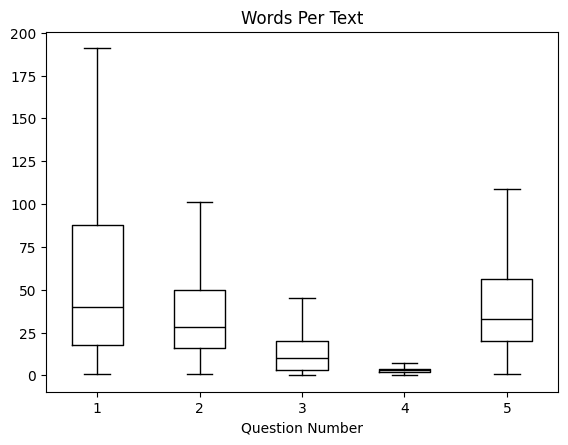

In [8]:
# INFO: 質問ごとの単語数の分布を確認
train.boxplot(
    column="Words Per Text",
    by="question_number",
    grid=False,
    showfliers=False,
    color="black",
)
plt.suptitle("")
plt.xlabel("Question Number")
plt.show()

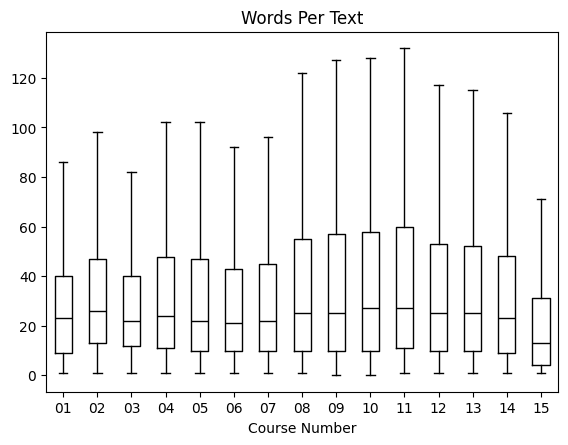

In [9]:
# INFO: 講義回数ごとの単語数の分布を確認
train.boxplot(
    column="Words Per Text",
    by="course_number",
    grid=False,
    showfliers=False,
    color="black",
)
plt.suptitle("")
plt.xlabel("Course Number")
plt.show()

## データを数値化してlightGBMに突っ込む

### 生徒のデータ形式

- `user_1`:
  - 1-1, 1-2, 1-3, 1-4, 1-5  
  - 2-1, 2-2, ..., 2-5  
  - ...  
  - 15-1, ..., 15-5

- `user_2`:
  - ...

- 各生徒の持つデータ数は膨大
- しかし全て有用であるため、とりあえず平均を使用して対応
- 質問番号は"1"のみ用いることとする

In [10]:
Input_df = pd.DataFrame()
Valid_df = pd.DataFrame()

### 1. 各文章の単語数
大事だと思うから，全て突っ込む<br>
数値の動きを擬似的な関数として定義するのもありかもしれないが，あとで考える

In [11]:
filter = "1"
temp = train.copy()
temp["text"] = train["Words Per Text"]
temp.head()

,userid,grade,text,course_number,question_number,label,Words Per Text
0,C-2022-1_U72,C,18,01,1,2,18
1,C-2021-1_U70,D,12,01,1,3,12
2,C-2021-2_U103,B,74,01,1,1,74
3,C-2021-2_U139,B,38,01,1,1,38
4,C-2022-1_U7,C,12,01,1,2,12


In [12]:
Qfilter_df = dm.encode(temp, logger=logger, filter=filter)
Input_df = pd.concat([Input_df, Qfilter_df])
Input_df = Input_df.replace("[NA]", 0)
Input_df.head()

/home/masa1357/Dockerdata/gitfile/Tree-Model/src/python/data_manager.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_column"] = df.apply(create_column_name, axis=1)


new_column,userid,label,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15
0,C-2021-1_U1,4,30,87,80,61,125,87,122,0,0,0,0,0,0,0,0
1,C-2021-1_U10,1,67,29,34,19,25,14,15,15,30,19,14,43,19,23,6
2,C-2021-1_U102,1,18,43,18,25,22,37,45,33,38,71,30,64,50,22,38
3,C-2021-1_U104,1,35,25,38,33,39,18,39,20,48,70,29,56,75,42,38
4,C-2021-1_U105,1,25,113,69,55,100,102,56,87,116,60,76,85,60,72,3


In [13]:
valid["Words Per Text"] = valid["text"].apply(count_words)
temp = valid.copy()
temp["text"] = valid["Words Per Text"]
Qfilter_df = dm.encode(temp, logger=logger, filter=filter)
Valid_df = pd.concat([Valid_df, Qfilter_df])
Valid_df = Valid_df.replace("[NA]", 0)
Valid_df.head()

/home/masa1357/Dockerdata/gitfile/Tree-Model/src/python/data_manager.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_column"] = df.apply(create_column_name, axis=1)


new_column,userid,label,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15
0,C-2021-1_U100,2,11,20,6,20,10,6,9,4,7,9,23,17,7,20,2
1,C-2021-1_U101,1,40,103,73,147,92,143,202,150,146,109,218,184,290,170,5
2,C-2021-1_U103,1,33,45,45,51,52,53,96,90,89,91,110,52,50,138,2
3,C-2021-1_U107,2,0,0,0,10,3,15,7,3,1,6,4,5,11,25,2
4,C-2021-1_U12,1,60,10,14,35,29,20,21,9,70,28,107,58,31,73,9


### 2. 各文章内の0の数

In [14]:
Input_df["zero_count"] = Input_df.isin([0]).sum(axis=1)
Valid_df["zero_count"] = Valid_df.isin([0]).sum(axis=1)
Input_df.head()

new_column,userid,label,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,zero_count
0,C-2021-1_U1,4,30,87,80,61,125,87,122,0,0,0,0,0,0,0,0,8
1,C-2021-1_U10,1,67,29,34,19,25,14,15,15,30,19,14,43,19,23,6,0
2,C-2021-1_U102,1,18,43,18,25,22,37,45,33,38,71,30,64,50,22,38,0
3,C-2021-1_U104,1,35,25,38,33,39,18,39,20,48,70,29,56,75,42,38,0
4,C-2021-1_U105,1,25,113,69,55,100,102,56,87,116,60,76,85,60,72,3,0


### 3. 各文章のベクトル間距離
多すぎるので，平均 / 中央値で保管する<br>
使うのはユークリッド距離とコサイン距離

In [15]:
args: Dict[str, object] = {
    "logger": logger,
    "MODEL_PATH": MODEL_PATH,
    "seed": seed,
}

with util.timer("Load Model..."):
    gs = mp.GetSentenceVector(args, train[train["question_number"] == filter])

[Load Model...] start


100%|██████████| 3795/3795 [00:00<00:00, 9718.47it/s] 
2024-08-15 02:41:53,533 : python.util.python.Mecab_processing : INFO : 68 : loading word2vec model ...
2024-08-15 02:41:53,559 : python.util.python.Mecab_processing : INFO : 70 : model loaded.


[Load Model...] done in 0.42 s


In [16]:
def cosine_similarity(vec1, vec2):
    # ゼロベクトルのチェック
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0.0

    # SciPyのコサイン距離を使用してコサイン類似度を計算
    return 1 - distance.cosine(vec1, vec2)

In [17]:
def get_vector_distance(df, filter=1):
    logger.info(f"Start get_vector_distance")
    Enc_df = dm.encode(df=df, logger=logger, filter=filter)
    data_X = {}
    data_Y = {}
    texts = {}

    for j in range(1, 16):
        column_name = f"{j:02d}"
        columns = ["userid", column_name, "label"]
        with util.timer(f"GetSentenceVector:{column_name}"):
            data_X[j], data_Y[j], texts[j] = gs(df=Enc_df[columns], key=column_name)

    logger.info(f"get Euclidean Distance")
    distances_df = pd.DataFrame()
    with util.timer(f"Calculate Euclidean Distance:"):
        # 全ての行に対して繰り返す
        for j in range(len(data_X[1])):
            for i in range(1, 15):
                name = f"euc_{i}:{i+1}"
                vec1 = data_X[i].iloc[j].values
                vec2 = data_X[i + 1].iloc[j].values
                distances_df.loc[j, name] = np.linalg.norm(vec1 - vec2)
            # 全ての列の平均値を計算
            distances_df.loc[j, "euc_mean"] = distances_df.loc[j].mean()
    
    logger.info(f"get Cosine Distance")
    cosdist_df = pd.DataFrame()
    with util.timer(f"Calculate cosine Distance:"):
        for j in range(len(data_X[1])):
            for i in range(1, 15):
                name = f"cos_{i}:{i+1}"
                vec1 = data_X[i].iloc[j].values
                vec2 = data_X[i + 1].iloc[j].values
                cosdist_df.loc[j, name] = 1 - cosine_similarity(vec1, vec2)
            # 全ての列の平均値を計算
            cosdist_df.loc[j, "cos_mean"] = cosdist_df.loc[j].mean()
    cosdist_df["Category"] = data_Y[1]["category_id"]

    # df['Euclidean Distance'] = distances_df["mean"]
    # df['Cosine Distance'] = cosdist_df["mean"]
    
    return distances_df, cosdist_df

In [18]:
te_dist, tc_dist = get_vector_distance(train, filter=filter)
ve_dist, vc_dist = get_vector_distance(valid, filter=filter)

2024-08-15 02:41:53,585 : python.util : INFO : 2 : Start get_vector_distance
/home/masa1357/Dockerdata/gitfile/Tree-Model/src/python/data_manager.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_column"] = df.apply(create_column_name, axis=1)


[GetSentenceVector:01] start


299it [00:00, 6039.85it/s]


[GetSentenceVector:01] done in 0.07 s
[GetSentenceVector:02] start


299it [00:00, 5081.55it/s]


[GetSentenceVector:02] done in 0.07 s
[GetSentenceVector:03] start


299it [00:00, 6167.37it/s]


[GetSentenceVector:03] done in 0.06 s
[GetSentenceVector:04] start


299it [00:00, 5212.68it/s]


[GetSentenceVector:04] done in 0.07 s
[GetSentenceVector:05] start


299it [00:00, 5206.94it/s]


[GetSentenceVector:05] done in 0.07 s
[GetSentenceVector:06] start


299it [00:00, 4467.33it/s]


[GetSentenceVector:06] done in 0.08 s
[GetSentenceVector:07] start


299it [00:00, 4530.32it/s]


[GetSentenceVector:07] done in 0.08 s
[GetSentenceVector:08] start


299it [00:00, 3722.55it/s]


[GetSentenceVector:08] done in 0.10 s
[GetSentenceVector:09] start


299it [00:00, 3542.36it/s]


[GetSentenceVector:09] done in 0.10 s
[GetSentenceVector:10] start


299it [00:00, 3849.44it/s]


[GetSentenceVector:10] done in 0.09 s
[GetSentenceVector:11] start


299it [00:00, 3229.15it/s]


[GetSentenceVector:11] done in 0.11 s
[GetSentenceVector:12] start


299it [00:00, 4563.65it/s]


[GetSentenceVector:12] done in 0.08 s
[GetSentenceVector:13] start


299it [00:00, 4067.45it/s]


[GetSentenceVector:13] done in 0.09 s
[GetSentenceVector:14] start


299it [00:00, 3927.88it/s]


[GetSentenceVector:14] done in 0.09 s
[GetSentenceVector:15] start


299it [00:00, 23241.66it/s]
2024-08-15 02:41:54,872 : python.util : INFO : 14 : get Euclidean Distance


[GetSentenceVector:15] done in 0.03 s
[Calculate Euclidean Distance:] start


2024-08-15 02:41:55,756 : python.util : INFO : 27 : get Cosine Distance


[Calculate Euclidean Distance:] done in 0.88 s
[Calculate cosine Distance:] start


2024-08-15 02:41:56,707 : python.util : INFO : 2 : Start get_vector_distance
/home/masa1357/Dockerdata/gitfile/Tree-Model/src/python/data_manager.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_column"] = df.apply(create_column_name, axis=1)


[Calculate cosine Distance:] done in 0.95 s
[GetSentenceVector:01] start


75it [00:00, 5532.21it/s]


[GetSentenceVector:01] done in 0.02 s
[GetSentenceVector:02] start


75it [00:00, 3846.15it/s]


[GetSentenceVector:02] done in 0.03 s
[GetSentenceVector:03] start


75it [00:00, 4668.57it/s]


[GetSentenceVector:03] done in 0.03 s
[GetSentenceVector:04] start


75it [00:00, 3897.47it/s]


[GetSentenceVector:04] done in 0.03 s
[GetSentenceVector:05] start


75it [00:00, 3968.17it/s]


[GetSentenceVector:05] done in 0.03 s
[GetSentenceVector:06] start


75it [00:00, 3581.94it/s]


[GetSentenceVector:06] done in 0.03 s
[GetSentenceVector:07] start


75it [00:00, 3347.91it/s]


[GetSentenceVector:07] done in 0.03 s
[GetSentenceVector:08] start


75it [00:00, 3395.17it/s]


[GetSentenceVector:08] done in 0.03 s
[GetSentenceVector:09] start


75it [00:00, 2208.61it/s]


[GetSentenceVector:09] done in 0.04 s
[GetSentenceVector:10] start


75it [00:00, 2987.59it/s]


[GetSentenceVector:10] done in 0.03 s
[GetSentenceVector:11] start


75it [00:00, 2969.63it/s]


[GetSentenceVector:11] done in 0.03 s
[GetSentenceVector:12] start


75it [00:00, 3329.38it/s]


[GetSentenceVector:12] done in 0.03 s
[GetSentenceVector:13] start


75it [00:00, 3021.66it/s]


[GetSentenceVector:13] done in 0.03 s
[GetSentenceVector:14] start


75it [00:00, 3293.92it/s]


[GetSentenceVector:14] done in 0.03 s
[GetSentenceVector:15] start


75it [00:00, 23057.45it/s]
2024-08-15 02:41:57,186 : python.util : INFO : 14 : get Euclidean Distance
2024-08-15 02:41:57,413 : python.util : INFO : 27 : get Cosine Distance


[GetSentenceVector:15] done in 0.01 s
[Calculate Euclidean Distance:] start
[Calculate Euclidean Distance:] done in 0.23 s
[Calculate cosine Distance:] start
[Calculate cosine Distance:] done in 0.24 s


In [19]:
# Input_df = pd.concat([Input_df, te_dist, tc_dist], axis=1)
# Valid_df = pd.concat([Valid_df, ve_dist, vc_dist], axis=1)

In [20]:
Input_df

new_column,userid,label,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,zero_count
0,C-2021-1_U1,4,30,87,80,61,125,87,122,0,0,0,0,0,0,0,0,8
1,C-2021-1_U10,1,67,29,34,19,25,14,15,15,30,19,14,43,19,23,6,0
2,C-2021-1_U102,1,18,43,18,25,22,37,45,33,38,71,30,64,50,22,38,0
3,C-2021-1_U104,1,35,25,38,33,39,18,39,20,48,70,29,56,75,42,38,0
4,C-2021-1_U105,1,25,113,69,55,100,102,56,87,116,60,76,85,60,72,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,C-2022-1_U92,3,9,18,30,30,30,8,34,13,12,12,14,12,17,15,0,1
295,C-2022-1_U93,2,17,23,22,14,8,12,45,26,16,14,42,17,24,0,0,2
296,C-2022-1_U94,2,34,39,48,32,37,29,29,25,18,21,32,37,25,20,4,0
297,C-2022-1_U95,2,11,6,0,0,0,0,0,6,4,0,0,0,18,7,0,9


In [21]:
Valid_df

new_column,userid,label,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,zero_count
0,C-2021-1_U100,2,11,20,6,20,10,6,9,4,7,9,23,17,7,20,2,0
1,C-2021-1_U101,1,40,103,73,147,92,143,202,150,146,109,218,184,290,170,5,0
2,C-2021-1_U103,1,33,45,45,51,52,53,96,90,89,91,110,52,50,138,2,0
3,C-2021-1_U107,2,0,0,0,10,3,15,7,3,1,6,4,5,11,25,2,3
4,C-2021-1_U12,1,60,10,14,35,29,20,21,9,70,28,107,58,31,73,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,C-2022-1_U74,2,69,11,15,30,28,18,20,17,6,25,9,26,0,26,0,2
71,C-2022-1_U79,1,11,101,50,125,93,80,92,70,54,67,157,78,55,85,0,1
72,C-2022-1_U84,1,52,39,44,60,45,49,41,36,47,31,46,58,38,73,0,1
73,C-2022-1_U86,2,9,9,7,4,5,3,9,7,4,4,10,8,4,4,5,0


<Axes: title={'center': 'cos_mean'}, xlabel='Category'>

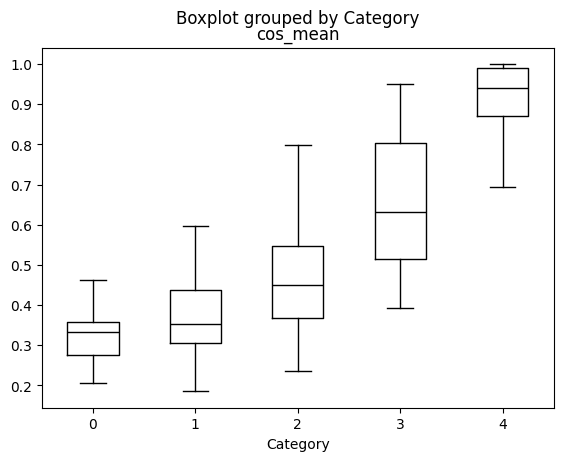

In [22]:
tc_dist.boxplot(column='cos_mean', by='Category', grid=False, showfliers=False, color='black')

<Axes: title={'center': 'cos_mean'}, xlabel='Category'>

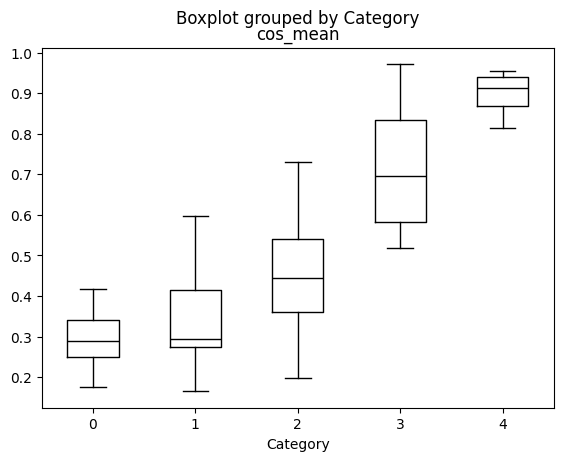

In [23]:
# INFO: このとき，Validを用いて分散表現を訓練していないことに留意すること．
vc_dist.boxplot(column='cos_mean', by='Category', grid=False, showfliers=False, color='black')

### LightGBM Model の訓練

In [24]:
import wandb

wandb.login()

wandb: Currently logged in as: masa1357. Use `wandb login --relogin` to force relogin


True

In [25]:
from wandb.integration.lightgbm import wandb_callback, log_summary
import lightgbm as lgb

In [26]:
params = {
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_iterations': 100,
    'max_depth': 7,
    'learning_rate': 0.01,
    'num_leaves': 31
}


# wandb.config.update(params)

In [27]:
def Tree_kfold(X_train, y_train, X_valid, y_valid, params, table=None):
    oof = np.zeros((X_train.shape[0], 5))
    prediction = np.zeros((X_valid.shape[0], 5))

    accuracies = []
    f1_scores = []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
        logger.info(f"Fold {fold + 1}")

        # Foldごとにデータを分割
        # train用データ：train_idxで指定されたデータ
        X_trn = X_train[train_idx]
        y_trn = y_train[train_idx]

        # valid用データ：valid_idxで指定されたデータ
        X_val = X_train[valid_idx]
        y_val = y_train[valid_idx]

        #Dataset化
        lgb_train = lgb.Dataset(X_trn, y_trn)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)


        # paramsが辞書形式か確認
        logger.info(params)
        logger.info("Train LightGBM Model")
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_eval],
            valid_names=["train", "valid"],
            callbacks=[wandb_callback(), lgb.early_stopping(stopping_rounds=100)],
        )
        logger.info("Predict Validation Data")
        oof[valid_idx] = model.predict(X_val, num_iteration=model.best_iteration)
        # prediction += (
        #     model.predict(X_valid, num_iteration=model.best_iteration) / kf.n_splits
        # )

        accuracy = accuracy_score(y_val, np.argmax(oof[valid_idx], axis=1))
        logger.info(f"Fold {fold + 1} Accuracy: {accuracy}")
        f1 = f1_score(y_val, np.argmax(oof[valid_idx], axis=1), average="macro")
        logger.info(f"Fold {fold + 1} F1 Score: {f1}")
        accuracies.append(accuracy)
        f1_scores.append(f1)
        
        # log wandb
        if table is not None:
            table.add_data(
                params.get("objective"),
                params.get("num_class"),
                params.get("metric"),
                params.get("boosting_type"),
                params.get("num_iterations"),
                params.get("max_depth"),
                params.get("learning_rate"),
                params.get("num_leaves"),
                params.get("verbosity"),
                fold + 1,
                accuracy,
                f1,
            )
            wandb.log({"Fold metrics": table})
        else:
            pass
            wandb.log({"Fold": fold + 1, "Accuracy": accuracy, "F1 Score": f1})

    final_accuracy = np.mean(accuracies)
    final_f1 = np.mean(f1_scores)
    logger.info(f"Final Accuracy: {final_accuracy}")
    logger.info(f"Final F1 Score: {final_f1}")

    # predict validation data
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    logger.info("Predict Validation Data")
    valmodel = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=["train", "valid"],
        callbacks=[wandb_callback(), lgb.early_stopping(stopping_rounds=100)],
    )
    prediction = valmodel.predict(X_valid, num_iteration=model.best_iteration)
    valid_accuracy = accuracy_score(y_valid, np.argmax(prediction, axis=1))
    valid_f1 = f1_score(y_valid, np.argmax(prediction, axis=1), average="macro")
    logger.info(f"Validation Accuracy: {valid_accuracy}")
    logger.info(f"Validation F1 Score: {valid_f1}")

    wandb.log({"Final Accuracy": final_accuracy, "Final F1 Score": final_f1})
    wandb.log({"Validation Accuracy": valid_accuracy, "Validation F1 Score": valid_f1})

In [28]:
def sweep():
    #global化
    global Input_df, Valid_df, te_dist, tc_dist, ve_dist, vc_dist

    wandb.init(project="Tree-Model", config=params)
    # config = params
    config = dict(wandb.config)
    #configから"use_data"を抜き出し，削除
    use_data = config.pop("use_data")
    #input, valid 定義
    input = pd.DataFrame()
    valid = pd.DataFrame()
    #use_dataを基にデータ結合
    match use_data:
        case "ALL":
            input = pd.concat([Input_df, te_dist, tc_dist], axis=1)
            valid = pd.concat([Valid_df, ve_dist, vc_dist], axis=1)
        case "NONE":
            input = Input_df.copy()
            valid = Valid_df.copy()
        case "euc":
            input = pd.concat([Input_df, te_dist], axis=1)
            valid = pd.concat([Valid_df, ve_dist], axis=1)
        case "cos":
            input = pd.concat([Input_df, tc_dist], axis=1)
            valid = pd.concat([Valid_df, vc_dist], axis=1)
            
    X_train = input.drop(["label", "userid"], axis=1)
    X_valid = valid.drop(["label", "userid"], axis=1)
    y_train = input["label"]
    y_valid = valid["label"]

    X_train = X_train.astype(float)
    X_valid = X_valid.astype(float)
    y_train = y_train.astype(float)
    y_valid = y_valid.astype(float)
    # logger.info(f"config: {config}")
    # config = {
    #     "objective": wandb.config.objective,
    #     "num_class": wandb.config.num_class,
    #     "metric": wandb.config.metric,
    #     # --sweep_config--
    #     "boosting_type": wandb.config.boosting_type,
    #     "num_iterations": wandb.config.num_iterations,
    #     "max_depth": wandb.config.max_depth,
    #     "learning_rate": wandb.config.learning_rate,
    #     "num_leaves": wandb.config.num_leaves,
    #     "verbosity": -1,
    # }
    columns = [
        "objective",
        "num_class",
        "metric",
        "boosting_type",
        "num_iterations",
        "max_depth",
        "learning_rate",
        "num_leaves",
        "verbosity",
        "accuracy",
        "f1",
    ]
    # table = wandb.Table(columns=columns)
    Tree_kfold(
        X_train.values,
        y_train.values,
        X_valid.values,
        y_valid.values,
        config,
    )

In [29]:
with open(BASE_PATH / "config" / "config.yaml", "r") as f:
    config = yaml.safe_load(f)
config = dict(config)

In [30]:
config

{'name': 'Tree_Model_use_vector_distance',
 'description': 'Tree Model',
 'method': 'random',
 'metric': {'name': 'F1 Score', 'goal': 'maximize'},
 'parameters': {'objective': {'value': 'multiclass'},
  'num_class': {'value': 5},
  'metric': {'value': 'multi_logloss'},
  'verbosity': {'value': -1},
  'boosting_type': {'values': ['gbdt', 'dart']},
  'num_iterations': {'min': 1000, 'max': 10000},
  'max_depth': {'min': 3, 'max': 10},
  'learning_rate': {'min': 0.01, 'max': 0.1},
  'num_leaves': {'min': 10, 'max': 100},
  'class_weight': {'values': ['None', 'balanced']},
  'use_data': {'values': ['euc', 'cos', 'ALL', 'NONE']}}}

In [31]:
sweep_id = wandb.sweep(sweep=config, project="Tree-Model")

wandb.agent(sweep_id, function=sweep, count=50)

Create sweep with ID: gszu4ra5
Sweep URL: https://wandb.ai/masa1357/Tree-Model/sweeps/gszu4ra5


wandb: Agent Starting Run: txv0voqx with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.029811249466095105
wandb: 	max_depth: 4
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 8482
wandb: 	num_leaves: 62
wandb: 	objective: multiclass
wandb: 	use_data: ALL
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 02:42:03,056 : python.util : INFO : 10 : Fold 1
2024-08-15 02:42:03,057 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8482, 'max_depth': 4, 'learning_rate': 0.029811249466095105, 'num_leaves': 62, 'class_weight': 'balanced'}
2024-08-15 02:42:03,058 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' w

Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:04,366 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:04,369 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 02:42:04,372 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 02:42:04,373 : python.util : INFO : 10 : Fold 2
2024-08-15 02:42:04,374 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8482, 'max_depth': 4, 'learning_rate': 0.029811249466095105, 'num_leaves': 62, 'class_weight': 'balanced'}
2024-08-15 02:42:04,374 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[309]	train's multi_logloss: 1.79165e-05	valid's multi_logloss: 1.90301e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:08,044 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:08,047 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 02:42:08,050 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 02:42:08,051 : python.util : INFO : 10 : Fold 3
2024-08-15 02:42:08,052 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8482, 'max_depth': 4, 'learning_rate': 0.029811249466095105, 'num_leaves': 62, 'class_weight': 'balanced'}
2024-08-15 02:42:08,052 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[745]	train's multi_logloss: 1.61651e-05	valid's multi_logloss: 2.62955e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:09,341 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:09,344 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 02:42:09,347 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 02:42:09,347 : python.util : INFO : 10 : Fold 4
2024-08-15 02:42:09,348 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8482, 'max_depth': 4, 'learning_rate': 0.029811249466095105, 'num_leaves': 62, 'class_weight': 'balanced'}
2024-08-15 02:42:09,349 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[438]	train's multi_logloss: 1.73668e-05	valid's multi_logloss: 3.18718e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:10,386 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:10,389 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 02:42:10,392 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 02:42:10,392 : python.util : INFO : 10 : Fold 5
2024-08-15 02:42:10,393 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8482, 'max_depth': 4, 'learning_rate': 0.029811249466095105, 'num_leaves': 62, 'class_weight': 'balanced'}
2024-08-15 02:42:10,394 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[304]	train's multi_logloss: 1.82424e-05	valid's multi_logloss: 1.84463e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:11,361 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:11,364 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 02:42:11,367 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 02:42:11,367 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 02:42:11,368 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 02:42:11,369 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[256]	train's multi_logloss: 1.95941e-05	valid's multi_logloss: 2.70875e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:13,290 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 02:42:13,291 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[541]	train's multi_logloss: 1.35165e-05	valid's multi_logloss: 1.73466e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▃▄▁▂▂▃▄▅▅▆▇▇█▁▂▃▃▄▅▆▁▂▃▄▄▂▂▃▄▁▂▃▃▄▅▅▆
train_multi_logloss,▃▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
valid_multi_logloss,▃▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
Accuracy,1.0


wandb: Agent Starting Run: tt79xt8z with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.055291970145420845
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 8468
wandb: 	num_leaves: 12
wandb: 	objective: multiclass
wandb: 	use_data: ALL
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 02:42:24,965 : python.util : INFO : 10 : Fold 1
2024-08-15 02:42:24,966 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8468, 'max_depth': 9, 'learning_rate': 0.055291970145420845, 'num_leaves': 12, 'class_weight': 'balanced'}
2024-08-15 02:42:24,967 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' w

Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:25,980 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:25,982 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 02:42:25,985 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 02:42:25,986 : python.util : INFO : 10 : Fold 2
2024-08-15 02:42:25,987 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8468, 'max_depth': 9, 'learning_rate': 0.055291970145420845, 'num_leaves': 12, 'class_weight': 'balanced'}
2024-08-15 02:42:25,987 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[169]	train's multi_logloss: 1.77723e-05	valid's multi_logloss: 1.90495e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:27,835 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:27,839 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 02:42:27,842 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 02:42:27,843 : python.util : INFO : 10 : Fold 3
2024-08-15 02:42:27,844 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8468, 'max_depth': 9, 'learning_rate': 0.055291970145420845, 'num_leaves': 12, 'class_weight': 'balanced'}
2024-08-15 02:42:27,844 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[422]	train's multi_logloss: 1.59755e-05	valid's multi_logloss: 2.65463e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:28,540 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:28,544 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 02:42:28,547 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 02:42:28,547 : python.util : INFO : 10 : Fold 4
2024-08-15 02:42:28,548 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8468, 'max_depth': 9, 'learning_rate': 0.055291970145420845, 'num_leaves': 12, 'class_weight': 'balanced'}
2024-08-15 02:42:28,549 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[141]	train's multi_logloss: 1.93112e-05	valid's multi_logloss: 3.24529e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:29,263 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:29,268 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 02:42:29,270 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 02:42:29,271 : python.util : INFO : 10 : Fold 5
2024-08-15 02:42:29,272 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8468, 'max_depth': 9, 'learning_rate': 0.055291970145420845, 'num_leaves': 12, 'class_weight': 'balanced'}
2024-08-15 02:42:29,272 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sw

Early stopping, best iteration is:
[160]	train's multi_logloss: 1.82097e-05	valid's multi_logloss: 1.83955e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:29,986 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:42:29,989 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 02:42:29,993 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 02:42:29,994 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 02:42:29,994 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 02:42:29,995 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[141]	train's multi_logloss: 1.90531e-05	valid's multi_logloss: 2.63432e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 02:42:32,011 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 02:42:32,012 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[289]	train's multi_logloss: 1.34209e-05	valid's multi_logloss: 1.75345e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▂▃▄▄▁▂▃▃▄▅▅▆▇▇█▁▂▃▄▁▂▂▃▄▄▁▂▃▃▄▁▂▃▃▄▅▅▆
train_multi_logloss,▄▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁
valid_multi_logloss,▅▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁█▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁
Accuracy,1.0


wandb: Agent Starting Run: u84xws3b with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: None
wandb: 	learning_rate: 0.05008589597969481
wandb: 	max_depth: 10
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 5588
wandb: 	num_leaves: 32
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 02:42:41,939 : python.util : INFO : 10 : Fold 1
2024-08-15 02:42:41,941 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 5588, 'max_depth': 10, 'learning_rate': 0.05008589597969481, 'num_leaves': 32, 'class_weight': 'None'}
2024-08-15 02:42:41,942 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was l

Accuracy,▁▅█▅▆
F1 Score,▁▇▇▂█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▂▂▄▄▆▇█▂▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▆▇█▂▂▄▅▆▇▁▂▃▅▅▇█
train_multi_logloss,▂▁▁▁▁▁▁▂▁▁▁▁▁█▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁
valid_multi_logloss,▃▅▇▇▇██▂▄▄▅▅▅▁▂▅▅▅▅▆▁▃▅▅▆▆▆▂▃▄▄▄▄▁▃▆▇▇▇▇
Accuracy,0.61017


wandb: Agent Starting Run: 0v61g9wq with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.05578806971535448
wandb: 	max_depth: 8
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 7709
wandb: 	num_leaves: 53
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 02:48:43,590 : python.util : INFO : 10 : Fold 1
2024-08-15 02:48:43,592 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 7709, 'max_depth': 8, 'learning_rate': 0.05578806971535448, 'num_leaves': 53, 'class_weight': 'balanced'}
2024-08-15 02:48:43,592 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Training until validation scores don't improve for 100 rounds


2024-08-15 02:48:44,303 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:48:44,306 : python.util : INFO : 43 : Fold 1 Accuracy: 0.5166666666666667
2024-08-15 02:48:44,308 : python.util : INFO : 45 : Fold 1 F1 Score: 0.39940179461615155
2024-08-15 02:48:44,309 : python.util : INFO : 10 : Fold 2
2024-08-15 02:48:44,310 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 7709, 'max_depth': 8, 'learning_rate': 0.05578806971535448, 'num_leaves': 53, 'class_weight': 'balanced'}
2024-08-15 02:48:44,310 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item

Early stopping, best iteration is:
[28]	train's multi_logloss: 0.447621	valid's multi_logloss: 0.920587
Training until validation scores don't improve for 100 rounds


2024-08-15 02:48:44,841 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:48:44,844 : python.util : INFO : 43 : Fold 2 Accuracy: 0.65
2024-08-15 02:48:44,847 : python.util : INFO : 45 : Fold 2 F1 Score: 0.5802293202293202
2024-08-15 02:48:44,848 : python.util : INFO : 10 : Fold 3
2024-08-15 02:48:44,848 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 7709, 'max_depth': 8, 'learning_rate': 0.05578806971535448, 'num_leaves': 53, 'class_weight': 'balanced'}
2024-08-15 02:48:44,849 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' wa

Early stopping, best iteration is:
[52]	train's multi_logloss: 0.229778	valid's multi_logloss: 0.927778
Training until validation scores don't improve for 100 rounds


2024-08-15 02:48:45,423 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:48:45,426 : python.util : INFO : 43 : Fold 3 Accuracy: 0.65
2024-08-15 02:48:45,429 : python.util : INFO : 45 : Fold 3 F1 Score: 0.502360005585812
2024-08-15 02:48:45,430 : python.util : INFO : 10 : Fold 4
2024-08-15 02:48:45,430 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 7709, 'max_depth': 8, 'learning_rate': 0.05578806971535448, 'num_leaves': 53, 'class_weight': 'balanced'}
2024-08-15 02:48:45,431 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was

Early stopping, best iteration is:
[35]	train's multi_logloss: 0.358765	valid's multi_logloss: 0.913854
Training until validation scores don't improve for 100 rounds


2024-08-15 02:48:45,914 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:48:45,918 : python.util : INFO : 43 : Fold 4 Accuracy: 0.6833333333333333
2024-08-15 02:48:45,920 : python.util : INFO : 45 : Fold 4 F1 Score: 0.5068839075688392
2024-08-15 02:48:45,921 : python.util : INFO : 10 : Fold 5
2024-08-15 02:48:45,922 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 7709, 'max_depth': 8, 'learning_rate': 0.05578806971535448, 'num_leaves': 53, 'class_weight': 'balanced'}
2024-08-15 02:48:45,923 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 

Early stopping, best iteration is:
[30]	train's multi_logloss: 0.446343	valid's multi_logloss: 0.896302
Training until validation scores don't improve for 100 rounds


2024-08-15 02:48:46,535 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:48:46,540 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6779661016949152
2024-08-15 02:48:46,542 : python.util : INFO : 45 : Fold 5 F1 Score: 0.590851370851371
2024-08-15 02:48:46,543 : python.util : INFO : 72 : Final Accuracy: 0.635593220338983
2024-08-15 02:48:46,544 : python.util : INFO : 73 : Final F1 Score: 0.5159452797702988
2024-08-15 02:48:46,544 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was lo

Early stopping, best iteration is:
[53]	train's multi_logloss: 0.236103	valid's multi_logloss: 0.916124
Training until validation scores don't improve for 100 rounds


2024-08-15 02:48:47,017 : python.util : INFO : 89 : Validation Accuracy: 0.6266666666666667
2024-08-15 02:48:47,017 : python.util : INFO : 90 : Validation F1 Score: 0.5045276292335116


Early stopping, best iteration is:
[31]	train's multi_logloss: 0.393135	valid's multi_logloss: 0.904382


Accuracy,▁▇▇██
F1 Score,▁█▅▅█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▇▂▃▄▅▆▇█▁▃▃▅▆▆▁▂▃▄▅▆▁▂▃▄▅▆▇█▁▂▄▄▆▇
train_multi_logloss,█▅▃▂▁▁▁▅▃▂▂▁▁▁▆▃▂▂▁▁▇▅▃▂▂▁█▅▃▂▂▁▁▁▆▃▂▂▁▁
valid_multi_logloss,▃▁▂▂▃▅▆▃▁▂▂▂▃▅▂▁▂▄▅▇▃▁▁▃▄▆▆▂▁▁▂▄▅▆▂▁▂▃▆█
Accuracy,0.67797


wandb: Agent Starting Run: tiefvjpp with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.013860378633594388
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 2378
wandb: 	num_leaves: 87
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 02:48:59,459 : python.util : INFO : 10 : Fold 1
2024-08-15 02:48:59,460 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2378, 'max_depth': 9, 'learning_rate': 0.013860378633594388, 'num_leaves': 87, 'class_weight': 'balanced'}
2024-08-15 02:48:59,460 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' w

Training until validation scores don't improve for 100 rounds


2024-08-15 02:49:00,834 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:49:00,837 : python.util : INFO : 43 : Fold 1 Accuracy: 0.5833333333333334
2024-08-15 02:49:00,840 : python.util : INFO : 45 : Fold 1 F1 Score: 0.4598997493734336
2024-08-15 02:49:00,841 : python.util : INFO : 10 : Fold 2
2024-08-15 02:49:00,842 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2378, 'max_depth': 9, 'learning_rate': 0.013860378633594388, 'num_leaves': 87, 'class_weight': 'balanced'}
2024-08-15 02:49:00,842 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item

Early stopping, best iteration is:
[97]	train's multi_logloss: 0.556052	valid's multi_logloss: 1.00504
Training until validation scores don't improve for 100 rounds


2024-08-15 02:49:02,116 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:49:02,120 : python.util : INFO : 43 : Fold 2 Accuracy: 0.6
2024-08-15 02:49:02,122 : python.util : INFO : 45 : Fold 2 F1 Score: 0.49972715572715576
2024-08-15 02:49:02,123 : python.util : INFO : 10 : Fold 3
2024-08-15 02:49:02,124 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2378, 'max_depth': 9, 'learning_rate': 0.013860378633594388, 'num_leaves': 87, 'class_weight': 'balanced'}
2024-08-15 02:49:02,125 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' w

Early stopping, best iteration is:
[238]	train's multi_logloss: 0.263559	valid's multi_logloss: 0.946219
Training until validation scores don't improve for 100 rounds


2024-08-15 02:49:03,048 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:49:03,051 : python.util : INFO : 43 : Fold 3 Accuracy: 0.6666666666666666
2024-08-15 02:49:03,054 : python.util : INFO : 45 : Fold 3 F1 Score: 0.5295095948827292
2024-08-15 02:49:03,055 : python.util : INFO : 10 : Fold 4
2024-08-15 02:49:03,056 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2378, 'max_depth': 9, 'learning_rate': 0.013860378633594388, 'num_leaves': 87, 'class_weight': 'balanced'}
2024-08-15 02:49:03,057 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item

Early stopping, best iteration is:
[182]	train's multi_logloss: 0.348589	valid's multi_logloss: 0.896307
Training until validation scores don't improve for 100 rounds


2024-08-15 02:49:03,986 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:49:03,990 : python.util : INFO : 43 : Fold 4 Accuracy: 0.7
2024-08-15 02:49:03,993 : python.util : INFO : 45 : Fold 4 F1 Score: 0.5135607635607636
2024-08-15 02:49:03,994 : python.util : INFO : 10 : Fold 5
2024-08-15 02:49:03,994 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2378, 'max_depth': 9, 'learning_rate': 0.013860378633594388, 'num_leaves': 87, 'class_weight': 'balanced'}
2024-08-15 02:49:03,995 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' wa

Early stopping, best iteration is:
[106]	train's multi_logloss: 0.565785	valid's multi_logloss: 0.872747
Training until validation scores don't improve for 100 rounds


2024-08-15 02:49:05,900 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:49:05,903 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6440677966101694
2024-08-15 02:49:05,905 : python.util : INFO : 45 : Fold 5 F1 Score: 0.5709306637004078
2024-08-15 02:49:05,906 : python.util : INFO : 72 : Final Accuracy: 0.6388135593220339
2024-08-15 02:49:05,907 : python.util : INFO : 73 : Final F1 Score: 0.5147255854488979
2024-08-15 02:49:05,908 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was 

Early stopping, best iteration is:
[313]	train's multi_logloss: 0.174607	valid's multi_logloss: 0.82221
Training until validation scores don't improve for 100 rounds


2024-08-15 02:49:06,905 : python.util : INFO : 89 : Validation Accuracy: 0.6
2024-08-15 02:49:06,906 : python.util : INFO : 90 : Validation F1 Score: 0.5405704099821748


Early stopping, best iteration is:
[175]	train's multi_logloss: 0.339466	valid's multi_logloss: 0.977964


Accuracy,▁▂▆█▅
F1 Score,▁▄▅▄█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▂▃▄▁▂▃▄▄▅▆▇▁▂▃▄▄▅▁▂▂▃▄▁▂▃▃▄▅▆▇▇█▁▂▃▄▅▅
train_multi_logloss,█▆▄▃▃▇▅▄▃▂▂▂▁▆▅▄▃▂▂█▆▄▄▃█▅▄▃▃▂▂▁▁▁▆▅▄▃▂▂
valid_multi_logloss,▇▅▄▅▅█▅▄▄▄▃▄▄▅▄▃▂▂▃▆▄▂▂▃█▄▂▂▁▁▁▁▁▁▅▄▄▄▄▄
Accuracy,0.64407


wandb: Agent Starting Run: jr7c7fgn with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.06971531647105891
wandb: 	max_depth: 3
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 1579
wandb: 	num_leaves: 27
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 02:49:19,922 : python.util : INFO : 10 : Fold 1
2024-08-15 02:49:19,923 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 1579, 'max_depth': 3, 'learning_rate': 0.06971531647105891, 'num_leaves': 27, 'class_weight': 'balanced'}
2024-08-15 02:49:19,924 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Accuracy,▁▃█▇▆
F1 Score,▁▃▅▃█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▇█▂▂▄▅▆▇▁▂▃▄▅▆▇▁▃▄▅▅▇█▂▃▄▅▆▇▁▂▃▅▆▇█
train_multi_logloss,▆▃▂▁▁▁▁▄▃▂▁▁▁█▃▁▁▁▁▁▆▂▁▁▁▁▁▅▂▁▁▁▁█▃▂▁▁▁▁
valid_multi_logloss,▁▂▃▄▆▇█▁▁▂▃▄▄▁▁▃▄▅▆▆▁▂▃▄▄▅▆▁▂▂▃▄▄▁▂▃▄▅▆▇
Accuracy,0.61017


wandb: Agent Starting Run: 9hkh94mp with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.08394385087424944
wandb: 	max_depth: 5
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 5845
wandb: 	num_leaves: 84
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 02:50:43,331 : python.util : INFO : 10 : Fold 1
2024-08-15 02:50:43,332 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 5845, 'max_depth': 5, 'learning_rate': 0.08394385087424944, 'num_leaves': 84, 'class_weight': 'None'}
2024-08-15 02:50:43,333 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Training until validation scores don't improve for 100 rounds


2024-08-15 02:50:44,068 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:50:44,072 : python.util : INFO : 43 : Fold 1 Accuracy: 0.6
2024-08-15 02:50:44,075 : python.util : INFO : 45 : Fold 1 F1 Score: 0.466304958301101
2024-08-15 02:50:44,076 : python.util : INFO : 10 : Fold 2
2024-08-15 02:50:44,076 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 5845, 'max_depth': 5, 'learning_rate': 0.08394385087424944, 'num_leaves': 84, 'class_weight': 'None'}
2024-08-15 02:50:44,077 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was lock

Early stopping, best iteration is:
[14]	train's multi_logloss: 0.625706	valid's multi_logloss: 0.988421
Training until validation scores don't improve for 100 rounds


2024-08-15 02:50:44,714 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:50:44,717 : python.util : INFO : 43 : Fold 2 Accuracy: 0.6333333333333333
2024-08-15 02:50:44,720 : python.util : INFO : 45 : Fold 2 F1 Score: 0.5333676386506575
2024-08-15 02:50:44,721 : python.util : INFO : 10 : Fold 3
2024-08-15 02:50:44,722 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 5845, 'max_depth': 5, 'learning_rate': 0.08394385087424944, 'num_leaves': 84, 'class_weight': 'None'}
2024-08-15 02:50:44,722 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num

Early stopping, best iteration is:
[36]	train's multi_logloss: 0.31277	valid's multi_logloss: 0.931366
Training until validation scores don't improve for 100 rounds


2024-08-15 02:50:45,281 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:50:45,284 : python.util : INFO : 43 : Fold 3 Accuracy: 0.65
2024-08-15 02:50:45,286 : python.util : INFO : 45 : Fold 3 F1 Score: 0.5227901131126937
2024-08-15 02:50:45,287 : python.util : INFO : 10 : Fold 4
2024-08-15 02:50:45,288 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 5845, 'max_depth': 5, 'learning_rate': 0.08394385087424944, 'num_leaves': 84, 'class_weight': 'None'}
2024-08-15 02:50:45,288 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was lo

Early stopping, best iteration is:
[37]	train's multi_logloss: 0.288035	valid's multi_logloss: 0.891199
Training until validation scores don't improve for 100 rounds


2024-08-15 02:50:45,673 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:50:45,677 : python.util : INFO : 43 : Fold 4 Accuracy: 0.6833333333333333
2024-08-15 02:50:45,679 : python.util : INFO : 45 : Fold 4 F1 Score: 0.5059163059163059
2024-08-15 02:50:45,680 : python.util : INFO : 10 : Fold 5
2024-08-15 02:50:45,681 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 5845, 'max_depth': 5, 'learning_rate': 0.08394385087424944, 'num_leaves': 84, 'class_weight': 'None'}
2024-08-15 02:50:45,682 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num

Early stopping, best iteration is:
[16]	train's multi_logloss: 0.602369	valid's multi_logloss: 0.885743
Training until validation scores don't improve for 100 rounds


2024-08-15 02:50:46,205 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 02:50:46,210 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6440677966101694
2024-08-15 02:50:46,212 : python.util : INFO : 45 : Fold 5 F1 Score: 0.5805941185251531
2024-08-15 02:50:46,213 : python.util : INFO : 72 : Final Accuracy: 0.6421468926553672
2024-08-15 02:50:46,213 : python.util : INFO : 73 : Final F1 Score: 0.5217946269011822
2024-08-15 02:50:46,214 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was 

Early stopping, best iteration is:
[52]	train's multi_logloss: 0.199736	valid's multi_logloss: 0.843575
Training until validation scores don't improve for 100 rounds


2024-08-15 02:50:46,630 : python.util : INFO : 89 : Validation Accuracy: 0.6
2024-08-15 02:50:46,630 : python.util : INFO : 90 : Validation F1 Score: 0.4572294843863471


Early stopping, best iteration is:
[22]	train's multi_logloss: 0.466378	valid's multi_logloss: 0.964948


Accuracy,▁▄▅█▅
F1 Score,▁▅▄▃█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▇▁▃▃▅▆▇█▂▃▃▅▆▇█▂▃▄▅▆▇▂▃▄▅▆▇█▁▂▃▄▅▆█
train_multi_logloss,▆▃▂▂▁▁▆▃▂▂▁▁▁▅▃▂▂▁▁▁▅▃▂▂▁▁▄▃▂▂▁▁▁█▄▂▂▁▁▁
valid_multi_logloss,▃▃▄▅▆█▄▂▂▃▃▄▅▂▂▂▃▄▅▆▂▂▃▃▃▄▂▁▁▁▂▃▄▅▂▂▃▄▅▆
Accuracy,0.64407


wandb: Agent Starting Run: 9okhywvl with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.032393845092518435
wandb: 	max_depth: 3
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 5253
wandb: 	num_leaves: 31
wandb: 	objective: multiclass
wandb: 	use_data: ALL
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 02:50:59,299 : python.util : INFO : 10 : Fold 1
2024-08-15 02:50:59,301 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 5253, 'max_depth': 3, 'learning_rate': 0.032393845092518435, 'num_leaves': 31, 'class_weight': 'balanced'}
2024-08-15 02:50:59,301 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' w

Accuracy,▆▁▆▆█
F1 Score,▆▅▇▁█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▇▁▃▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█▂▃▄▅▆▇▁▂▃▄▅▇█
train_multi_logloss,█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁
valid_multi_logloss,▂▁▁▁▁▁▂▁▁▁▃▅▇█▁▁▁▂▃▄▁▁▁▁▂▄▅▁▁▁▁▁▁▁▁▁▁▂▂▃
Accuracy,1.0


wandb: Agent Starting Run: zasi1sfz with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.08706492305127977
wandb: 	max_depth: 3
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 8053
wandb: 	num_leaves: 89
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 02:54:58,229 : python.util : INFO : 10 : Fold 1
2024-08-15 02:54:58,231 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 8053, 'max_depth': 3, 'learning_rate': 0.08706492305127977, 'num_leaves': 89, 'class_weight': 'balanced'}
2024-08-15 02:54:58,231 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Accuracy,▁█▇▂▃
F1 Score,█▆▂▁▃
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▅▆▆█▂▃▄▅▆▇▁▂▃▄▅▆█▁▃▄▅▆▇▁▂▃▄▅▆▇▁▂▃▄▆▇█
train_multi_logloss,▂▁▁▁▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▂▁▁▁▁▁█▁▁▁▁▁▁▆▁▁▁▁▁▁
valid_multi_logloss,▃▅▇▇▇▇█▂▄▄▄▄▅▁▃▄▅▅▆▆▂▄▅▅▆▆▁▃▄▄▄▅▅▁▅▇▇▇▇▇
Accuracy,0.55932


wandb: Agent Starting Run: glivvpkk with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.08209669336742491
wandb: 	max_depth: 7
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 9697
wandb: 	num_leaves: 26
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:01:33,964 : python.util : INFO : 10 : Fold 1
2024-08-15 03:01:33,965 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9697, 'max_depth': 7, 'learning_rate': 0.08209669336742491, 'num_leaves': 26, 'class_weight': 'None'}
2024-08-15 03:01:33,966 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Training until validation scores don't improve for 100 rounds


2024-08-15 03:01:35,977 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:01:35,979 : python.util : INFO : 43 : Fold 1 Accuracy: 0.6
2024-08-15 03:01:35,982 : python.util : INFO : 45 : Fold 1 F1 Score: 0.4745782757547463
2024-08-15 03:01:35,983 : python.util : INFO : 10 : Fold 2
2024-08-15 03:01:35,983 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9697, 'max_depth': 7, 'learning_rate': 0.08209669336742491, 'num_leaves': 26, 'class_weight': 'None'}
2024-08-15 03:01:35,984 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was loc

Early stopping, best iteration is:
[14]	train's multi_logloss: 0.607714	valid's multi_logloss: 0.991454
Training until validation scores don't improve for 100 rounds


2024-08-15 03:01:36,691 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:01:36,695 : python.util : INFO : 43 : Fold 2 Accuracy: 0.5833333333333334
2024-08-15 03:01:36,698 : python.util : INFO : 45 : Fold 2 F1 Score: 0.48129729729729726
2024-08-15 03:01:36,699 : python.util : INFO : 10 : Fold 3
2024-08-15 03:01:36,700 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9697, 'max_depth': 7, 'learning_rate': 0.08209669336742491, 'num_leaves': 26, 'class_weight': 'None'}
2024-08-15 03:01:36,700 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'nu

Early stopping, best iteration is:
[36]	train's multi_logloss: 0.29612	valid's multi_logloss: 0.945733
Training until validation scores don't improve for 100 rounds


2024-08-15 03:01:37,620 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:01:37,624 : python.util : INFO : 43 : Fold 3 Accuracy: 0.6833333333333333
2024-08-15 03:01:37,626 : python.util : INFO : 45 : Fold 3 F1 Score: 0.5268921095008052
2024-08-15 03:01:37,627 : python.util : INFO : 10 : Fold 4
2024-08-15 03:01:37,628 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9697, 'max_depth': 7, 'learning_rate': 0.08209669336742491, 'num_leaves': 26, 'class_weight': 'None'}
2024-08-15 03:01:37,629 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num

Early stopping, best iteration is:
[31]	train's multi_logloss: 0.340669	valid's multi_logloss: 0.889871
Training until validation scores don't improve for 100 rounds


2024-08-15 03:01:38,038 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:01:38,040 : python.util : INFO : 43 : Fold 4 Accuracy: 0.7
2024-08-15 03:01:38,043 : python.util : INFO : 45 : Fold 4 F1 Score: 0.5123633596236336
2024-08-15 03:01:38,044 : python.util : INFO : 10 : Fold 5
2024-08-15 03:01:38,045 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9697, 'max_depth': 7, 'learning_rate': 0.08209669336742491, 'num_leaves': 26, 'class_weight': 'None'}
2024-08-15 03:01:38,045 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was loc

Early stopping, best iteration is:
[17]	train's multi_logloss: 0.576864	valid's multi_logloss: 0.868538
Training until validation scores don't improve for 100 rounds


2024-08-15 03:01:38,585 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:01:38,589 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6271186440677966
2024-08-15 03:01:38,592 : python.util : INFO : 45 : Fold 5 F1 Score: 0.5196581196581197
2024-08-15 03:01:38,593 : python.util : INFO : 72 : Final Accuracy: 0.6387570621468927
2024-08-15 03:01:38,594 : python.util : INFO : 73 : Final F1 Score: 0.5029578323669204
2024-08-15 03:01:38,595 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was 

Early stopping, best iteration is:
[39]	train's multi_logloss: 0.274656	valid's multi_logloss: 0.841944
Training until validation scores don't improve for 100 rounds


2024-08-15 03:01:39,093 : python.util : INFO : 89 : Validation Accuracy: 0.5733333333333334
2024-08-15 03:01:39,094 : python.util : INFO : 90 : Validation F1 Score: 0.5053663003663005


Early stopping, best iteration is:
[31]	train's multi_logloss: 0.32275	valid's multi_logloss: 0.973784


Accuracy,▂▁▇█▄
F1 Score,▁▂█▆▇
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▇▁▂▃▄▆▇█▁▂▃▄▆▇█▁▃▄▅▆▇▁▂▄▅▆▇█▁▂▄▅▆▇█
train_multi_logloss,▇▄▃▂▁▁█▄▃▂▁▁▁█▄▃▂▁▁▁▇▃▂▂▁▁▆▄▂▂▁▁▁▆▄▂▂▁▁▁
valid_multi_logloss,▂▃▄▅▆█▄▂▂▃▄▄▅▃▁▂▂▃▄▅▂▂▂▃▄▄▂▁▁▁▂▂▃▂▂▃▃▄▅▆
Accuracy,0.62712


wandb: Agent Starting Run: yamlfvx5 with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: None
wandb: 	learning_rate: 0.012882856203662906
wandb: 	max_depth: 3
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 6121
wandb: 	num_leaves: 79
wandb: 	objective: multiclass
wandb: 	use_data: ALL
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:01:49,955 : python.util : INFO : 10 : Fold 1
2024-08-15 03:01:49,957 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 6121, 'max_depth': 3, 'learning_rate': 0.012882856203662906, 'num_leaves': 79, 'class_weight': 'None'}
2024-08-15 03:01:49,957 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was l

Accuracy,█▁███
F1 Score,█▁███
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▂▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▇█▁▂▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▇█
train_multi_logloss,▂▁▁▁▁▁▁▂▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▂▁▁▁▁▁▇▁▁▁▁▁▁
valid_multi_logloss,▂▁▁▁▁▁▁▂▁▁▁▁▁█▁▁▁▁▁▁▇▁▁▁▁▁▁▂▁▁▁▁▁▇▁▁▁▁▁▁
Accuracy,1.0


wandb: Agent Starting Run: 8a2t5uww with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.064214275917097
wandb: 	max_depth: 4
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 1721
wandb: 	num_leaves: 39
wandb: 	objective: multiclass
wandb: 	use_data: cos
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:06:47,332 : python.util : INFO : 10 : Fold 1
2024-08-15 03:06:47,333 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 1721, 'max_depth': 4, 'learning_rate': 0.064214275917097, 'num_leaves': 39, 'class_weight': 'None'}
2024-08-15 03:06:47,334 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lock

Training until validation scores don't improve for 100 rounds


2024-08-15 03:06:48,309 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:06:48,312 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 03:06:48,315 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 03:06:48,316 : python.util : INFO : 10 : Fold 2
2024-08-15 03:06:48,317 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 1721, 'max_depth': 4, 'learning_rate': 0.064214275917097, 'num_leaves': 39, 'class_weight': 'None'}
2024-08-15 03:06:48,317 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (i

Early stopping, best iteration is:
[144]	train's multi_logloss: 1.84546e-05	valid's multi_logloss: 1.97855e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:06:49,288 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:06:49,291 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 03:06:49,294 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 03:06:49,294 : python.util : INFO : 10 : Fold 3
2024-08-15 03:06:49,295 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 1721, 'max_depth': 4, 'learning_rate': 0.064214275917097, 'num_leaves': 39, 'class_weight': 'None'}
2024-08-15 03:06:49,296 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (i

Early stopping, best iteration is:
[211]	train's multi_logloss: 1.73949e-05	valid's multi_logloss: 2.69642e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:06:50,012 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:06:50,015 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 03:06:50,017 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 03:06:50,018 : python.util : INFO : 10 : Fold 4
2024-08-15 03:06:50,019 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 1721, 'max_depth': 4, 'learning_rate': 0.064214275917097, 'num_leaves': 39, 'class_weight': 'None'}
2024-08-15 03:06:50,020 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (i

Early stopping, best iteration is:
[168]	train's multi_logloss: 1.81012e-05	valid's multi_logloss: 2.21568e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:06:50,696 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:06:50,699 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 03:06:50,702 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 03:06:50,703 : python.util : INFO : 10 : Fold 5
2024-08-15 03:06:50,704 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 1721, 'max_depth': 4, 'learning_rate': 0.064214275917097, 'num_leaves': 39, 'class_weight': 'None'}
2024-08-15 03:06:50,704 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (i

Early stopping, best iteration is:
[170]	train's multi_logloss: 1.81865e-05	valid's multi_logloss: 1.79107e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:06:51,338 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:06:51,342 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 03:06:51,344 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 03:06:51,345 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 03:06:51,346 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 03:06:51,346 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[157]	train's multi_logloss: 1.81058e-05	valid's multi_logloss: 2.06149e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:06:52,160 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 03:06:52,160 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[190]	train's multi_logloss: 1.43777e-05	valid's multi_logloss: 1.79984e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▁▂▃▄▅▆▇█▂▂▄▅▆▇▁▂▃▄▅▆▇▁▃▄▅▆▆▁▃▃▄▅▆█
train_multi_logloss,▄▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
valid_multi_logloss,▅▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
Accuracy,1.0


wandb: Agent Starting Run: gixosquc with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: None
wandb: 	learning_rate: 0.06781234173030626
wandb: 	max_depth: 4
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 2603
wandb: 	num_leaves: 59
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:07:02,192 : python.util : INFO : 10 : Fold 1
2024-08-15 03:07:02,193 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 2603, 'max_depth': 4, 'learning_rate': 0.06781234173030626, 'num_leaves': 59, 'class_weight': 'None'}
2024-08-15 03:07:02,194 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Accuracy,▁▅█▆▅
F1 Score,▁▇▇▄█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆█▁▃▄▅▆▇▁▂▃▄▅▆▇▂▃▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
train_multi_logloss,▆▁▁▁▁▁▁▄▁▁▁▁▁█▂▁▁▁▁▁▃▁▁▁▁▁▁▂▁▁▁▁▁▅▁▁▁▁▁▁
valid_multi_logloss,▁▃▆▇███▁▂▃▅▅▆▁▂▄▆▆▆▇▁▄▆▇▇▇▇▁▂▄▅▆▆▁▃▅▆▇██
Accuracy,0.59322


wandb: Agent Starting Run: 5ism0q0s with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.03399623333913337
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 9167
wandb: 	num_leaves: 85
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:09:27,634 : python.util : INFO : 10 : Fold 1
2024-08-15 03:09:27,636 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9167, 'max_depth': 9, 'learning_rate': 0.03399623333913337, 'num_leaves': 85, 'class_weight': 'balanced'}
2024-08-15 03:09:27,637 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Training until validation scores don't improve for 100 rounds


2024-08-15 03:09:28,337 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:09:28,339 : python.util : INFO : 43 : Fold 1 Accuracy: 0.5666666666666667
2024-08-15 03:09:28,342 : python.util : INFO : 45 : Fold 1 F1 Score: 0.44882073356649627
2024-08-15 03:09:28,343 : python.util : INFO : 10 : Fold 2
2024-08-15 03:09:28,344 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9167, 'max_depth': 9, 'learning_rate': 0.03399623333913337, 'num_leaves': 85, 'class_weight': 'balanced'}
2024-08-15 03:09:28,345 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item

Early stopping, best iteration is:
[31]	train's multi_logloss: 0.64333	valid's multi_logloss: 1.01316
Training until validation scores don't improve for 100 rounds


2024-08-15 03:09:29,127 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:09:29,131 : python.util : INFO : 43 : Fold 2 Accuracy: 0.5833333333333334
2024-08-15 03:09:29,133 : python.util : INFO : 45 : Fold 2 F1 Score: 0.48893772893772897
2024-08-15 03:09:29,134 : python.util : INFO : 10 : Fold 3
2024-08-15 03:09:29,135 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9167, 'max_depth': 9, 'learning_rate': 0.03399623333913337, 'num_leaves': 85, 'class_weight': 'balanced'}
2024-08-15 03:09:29,135 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item

Early stopping, best iteration is:
[98]	train's multi_logloss: 0.256464	valid's multi_logloss: 0.952057
Training until validation scores don't improve for 100 rounds


2024-08-15 03:09:30,875 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:09:30,877 : python.util : INFO : 43 : Fold 3 Accuracy: 0.6666666666666666
2024-08-15 03:09:30,880 : python.util : INFO : 45 : Fold 3 F1 Score: 0.5295095948827292
2024-08-15 03:09:30,881 : python.util : INFO : 10 : Fold 4
2024-08-15 03:09:30,882 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9167, 'max_depth': 9, 'learning_rate': 0.03399623333913337, 'num_leaves': 85, 'class_weight': 'balanced'}
2024-08-15 03:09:30,883 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 

Early stopping, best iteration is:
[84]	train's multi_logloss: 0.301082	valid's multi_logloss: 0.889242
Training until validation scores don't improve for 100 rounds


2024-08-15 03:09:31,489 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:09:31,491 : python.util : INFO : 43 : Fold 4 Accuracy: 0.6833333333333333
2024-08-15 03:09:31,493 : python.util : INFO : 45 : Fold 4 F1 Score: 0.5059163059163059
2024-08-15 03:09:31,494 : python.util : INFO : 10 : Fold 5
2024-08-15 03:09:31,495 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9167, 'max_depth': 9, 'learning_rate': 0.03399623333913337, 'num_leaves': 85, 'class_weight': 'balanced'}
2024-08-15 03:09:31,496 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 

Early stopping, best iteration is:
[50]	train's multi_logloss: 0.516451	valid's multi_logloss: 0.877847
Training until validation scores don't improve for 100 rounds


2024-08-15 03:09:32,690 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:09:32,693 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6440677966101694
2024-08-15 03:09:32,696 : python.util : INFO : 45 : Fold 5 F1 Score: 0.5709306637004078
2024-08-15 03:09:32,696 : python.util : INFO : 72 : Final Accuracy: 0.6288135593220339
2024-08-15 03:09:32,697 : python.util : INFO : 73 : Final F1 Score: 0.5088230054007337
2024-08-15 03:09:32,698 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was 

Early stopping, best iteration is:
[118]	train's multi_logloss: 0.196624	valid's multi_logloss: 0.818124
Training until validation scores don't improve for 100 rounds


2024-08-15 03:09:33,339 : python.util : INFO : 89 : Validation Accuracy: 0.5733333333333334
2024-08-15 03:09:33,340 : python.util : INFO : 90 : Validation F1 Score: 0.4284920634920635


Early stopping, best iteration is:
[50]	train's multi_logloss: 0.466786	valid's multi_logloss: 0.964292


Accuracy,▁▂▇█▆
F1 Score,▁▃▆▄█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▃▄▁▂▃▃▄▅▆▇▁▂▃▄▅▆▆▁▂▃▄▄▅▁▂▃▄▅▆▆▇█▂▃▃▄▅
train_multi_logloss,█▆▄▃▂█▆▄▃▂▂▂▁▇▅▄▃▂▂▁█▆▄▃▂▂▇▅▄▃▂▂▁▁▁▆▄▃▂▂
valid_multi_logloss,▅▅▅▆█▇▅▄▄▄▅▆▇▅▃▂▂▃▄▅▄▂▂▄▄▅▅▃▁▁▁▁▂▃▃▄▄▄▅▆
Accuracy,0.64407


wandb: Agent Starting Run: 37nsdznj with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.013003619572865542
wandb: 	max_depth: 3
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 9410
wandb: 	num_leaves: 54
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:09:43,464 : python.util : INFO : 10 : Fold 1
2024-08-15 03:09:43,465 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9410, 'max_depth': 3, 'learning_rate': 0.013003619572865542, 'num_leaves': 54, 'class_weight': 'None'}
2024-08-15 03:09:43,466 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was l

Training until validation scores don't improve for 100 rounds


2024-08-15 03:09:44,626 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:09:44,629 : python.util : INFO : 43 : Fold 1 Accuracy: 0.5166666666666667
2024-08-15 03:09:44,631 : python.util : INFO : 45 : Fold 1 F1 Score: 0.38244047619047616
2024-08-15 03:09:44,632 : python.util : INFO : 10 : Fold 2
2024-08-15 03:09:44,633 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9410, 'max_depth': 3, 'learning_rate': 0.013003619572865542, 'num_leaves': 54, 'class_weight': 'None'}
2024-08-15 03:09:44,634 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n

Early stopping, best iteration is:
[195]	train's multi_logloss: 0.413937	valid's multi_logloss: 0.945477
Training until validation scores don't improve for 100 rounds


2024-08-15 03:09:45,746 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:09:45,749 : python.util : INFO : 43 : Fold 2 Accuracy: 0.6166666666666667
2024-08-15 03:09:45,752 : python.util : INFO : 45 : Fold 2 F1 Score: 0.5488995215311006
2024-08-15 03:09:45,753 : python.util : INFO : 10 : Fold 3
2024-08-15 03:09:45,754 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9410, 'max_depth': 3, 'learning_rate': 0.013003619572865542, 'num_leaves': 54, 'class_weight': 'None'}
2024-08-15 03:09:45,755 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'nu

Early stopping, best iteration is:
[227]	train's multi_logloss: 0.375024	valid's multi_logloss: 0.927518
Training until validation scores don't improve for 100 rounds


2024-08-15 03:09:46,645 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:09:46,648 : python.util : INFO : 43 : Fold 3 Accuracy: 0.65
2024-08-15 03:09:46,651 : python.util : INFO : 45 : Fold 3 F1 Score: 0.4971119482275669
2024-08-15 03:09:46,652 : python.util : INFO : 10 : Fold 4
2024-08-15 03:09:46,653 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9410, 'max_depth': 3, 'learning_rate': 0.013003619572865542, 'num_leaves': 54, 'class_weight': 'None'}
2024-08-15 03:09:46,653 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was l

Early stopping, best iteration is:
[211]	train's multi_logloss: 0.387362	valid's multi_logloss: 0.861898
Training until validation scores don't improve for 100 rounds


2024-08-15 03:09:47,432 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:09:47,434 : python.util : INFO : 43 : Fold 4 Accuracy: 0.6833333333333333
2024-08-15 03:09:47,437 : python.util : INFO : 45 : Fold 4 F1 Score: 0.5068839075688392
2024-08-15 03:09:47,438 : python.util : INFO : 10 : Fold 5
2024-08-15 03:09:47,439 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9410, 'max_depth': 3, 'learning_rate': 0.013003619572865542, 'num_leaves': 54, 'class_weight': 'None'}
2024-08-15 03:09:47,439 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'nu

Early stopping, best iteration is:
[156]	train's multi_logloss: 0.496169	valid's multi_logloss: 0.897971
Training until validation scores don't improve for 100 rounds


2024-08-15 03:09:48,806 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:09:48,808 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6101694915254238
2024-08-15 03:09:48,811 : python.util : INFO : 45 : Fold 5 F1 Score: 0.5224386724386724
2024-08-15 03:09:48,812 : python.util : INFO : 72 : Final Accuracy: 0.6153672316384181
2024-08-15 03:09:48,813 : python.util : INFO : 73 : Final F1 Score: 0.49155490519133105
2024-08-15 03:09:48,813 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was

Early stopping, best iteration is:
[367]	train's multi_logloss: 0.241449	valid's multi_logloss: 0.884805
Training until validation scores don't improve for 100 rounds


2024-08-15 03:09:49,504 : python.util : INFO : 89 : Validation Accuracy: 0.6533333333333333
2024-08-15 03:09:49,505 : python.util : INFO : 90 : Validation F1 Score: 0.5213547237076648


Early stopping, best iteration is:
[152]	train's multi_logloss: 0.520323	valid's multi_logloss: 0.894355


Accuracy,▁▅▇█▅
F1 Score,▁█▆▆▇
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▃▄▅▁▂▂▃▄▅▅▁▂▃▃▄▅▆▂▂▃▄▅▁▂▃▄▄▅▆▇▇█▁▂▃▄▅
train_multi_logloss,█▅▄▃▃▂█▅▄▃▃▂▂█▅▄▃▂▂▂▆▅▄▃▂▇▅▄▃▃▂▂▁▁▁▆▅▄▃▂
valid_multi_logloss,▅▃▂▂▂▃█▅▃▂▂▂▂▅▃▁▁▁▁▁▃▂▂▂▂▆▃▂▂▂▂▁▁▁▂▃▂▂▂▂
Accuracy,0.61017


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b4uiaxr9 with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.07367322292501871
wandb: 	max_depth: 5
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 9820
wandb: 	num_leaves: 50
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:10:09,377 : python.util : INFO : 10 : Fold 1
2024-08-15 03:10:09,378 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9820, 'max_depth': 5, 'learning_rate': 0.07367322292501871, 'num_leaves': 50, 'class_weight': 'None'}
2024-08-15 03:10:09,379 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:10,017 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:10,020 : python.util : INFO : 43 : Fold 1 Accuracy: 0.5833333333333334
2024-08-15 03:10:10,022 : python.util : INFO : 45 : Fold 1 F1 Score: 0.4555067155067155
2024-08-15 03:10:10,023 : python.util : INFO : 10 : Fold 2
2024-08-15 03:10:10,024 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9820, 'max_depth': 5, 'learning_rate': 0.07367322292501871, 'num_leaves': 50, 'class_weight': 'None'}
2024-08-15 03:10:10,025 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num

Early stopping, best iteration is:
[16]	train's multi_logloss: 0.621893	valid's multi_logloss: 1.01002
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:10,535 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:10,539 : python.util : INFO : 43 : Fold 2 Accuracy: 0.6166666666666667
2024-08-15 03:10:10,542 : python.util : INFO : 45 : Fold 2 F1 Score: 0.5132307692307693
2024-08-15 03:10:10,543 : python.util : INFO : 10 : Fold 3
2024-08-15 03:10:10,544 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9820, 'max_depth': 5, 'learning_rate': 0.07367322292501871, 'num_leaves': 50, 'class_weight': 'None'}
2024-08-15 03:10:10,545 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num

Early stopping, best iteration is:
[48]	train's multi_logloss: 0.262836	valid's multi_logloss: 0.951036
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:11,215 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:11,220 : python.util : INFO : 43 : Fold 3 Accuracy: 0.65
2024-08-15 03:10:11,222 : python.util : INFO : 45 : Fold 3 F1 Score: 0.5227901131126937
2024-08-15 03:10:11,223 : python.util : INFO : 10 : Fold 4
2024-08-15 03:10:11,224 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9820, 'max_depth': 5, 'learning_rate': 0.07367322292501871, 'num_leaves': 50, 'class_weight': 'None'}
2024-08-15 03:10:11,225 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was lo

Early stopping, best iteration is:
[40]	train's multi_logloss: 0.307932	valid's multi_logloss: 0.886096
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:11,647 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:11,650 : python.util : INFO : 43 : Fold 4 Accuracy: 0.6833333333333333
2024-08-15 03:10:11,652 : python.util : INFO : 45 : Fold 4 F1 Score: 0.5059163059163059
2024-08-15 03:10:11,653 : python.util : INFO : 10 : Fold 5
2024-08-15 03:10:11,654 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9820, 'max_depth': 5, 'learning_rate': 0.07367322292501871, 'num_leaves': 50, 'class_weight': 'None'}
2024-08-15 03:10:11,655 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num

Early stopping, best iteration is:
[23]	train's multi_logloss: 0.525943	valid's multi_logloss: 0.873375
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:12,226 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:12,229 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6610169491525424
2024-08-15 03:10:12,231 : python.util : INFO : 45 : Fold 5 F1 Score: 0.593626588465298
2024-08-15 03:10:12,232 : python.util : INFO : 72 : Final Accuracy: 0.6388700564971751
2024-08-15 03:10:12,233 : python.util : INFO : 73 : Final F1 Score: 0.5182140984463566
2024-08-15 03:10:12,234 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was l

Early stopping, best iteration is:
[56]	train's multi_logloss: 0.215081	valid's multi_logloss: 0.840527
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:14,350 : python.util : INFO : 89 : Validation Accuracy: 0.6266666666666667
2024-08-15 03:10:14,351 : python.util : INFO : 90 : Validation F1 Score: 0.48299663299663304


Early stopping, best iteration is:
[23]	train's multi_logloss: 0.494948	valid's multi_logloss: 0.959869


Accuracy,▁▃▆█▆
F1 Score,▁▄▄▄█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▁▂▃▄▅▆▇▁▂▃▄▅▆▇▁▂▃▄▅▆▁▂▃▄▅▆▇█▁▂▃▄▅▇
train_multi_logloss,▇▄▂▂▁▁▆▄▂▂▁▁▁▇▄▃▂▁▁▁█▄▃▂▂▁▇▄▃▂▁▁▁▁▆▄▂▂▁▁
valid_multi_logloss,▃▃▅▆▇█▄▃▂▃▃▄▅▃▂▂▂▄▅▆▄▁▂▃▃▄▃▁▁▁▂▂▄▄▃▂▃▃▅▆
Accuracy,0.66102


wandb: Agent Starting Run: goq8zcpc with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.056721344470829695
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 2579
wandb: 	num_leaves: 23
wandb: 	objective: multiclass
wandb: 	use_data: cos
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:10:27,255 : python.util : INFO : 10 : Fold 1
2024-08-15 03:10:27,256 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2579, 'max_depth': 9, 'learning_rate': 0.056721344470829695, 'num_leaves': 23, 'class_weight': 'None'}
2024-08-15 03:10:27,257 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was l

Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:28,259 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:28,262 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 03:10:28,264 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 03:10:28,265 : python.util : INFO : 10 : Fold 2
2024-08-15 03:10:28,266 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2579, 'max_depth': 9, 'learning_rate': 0.056721344470829695, 'num_leaves': 23, 'class_weight': 'None'}
2024-08-15 03:10:28,266 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep'

Early stopping, best iteration is:
[148]	train's multi_logloss: 1.90869e-05	valid's multi_logloss: 1.99372e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:29,250 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:29,253 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 03:10:29,256 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 03:10:29,257 : python.util : INFO : 10 : Fold 3
2024-08-15 03:10:29,257 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2579, 'max_depth': 9, 'learning_rate': 0.056721344470829695, 'num_leaves': 23, 'class_weight': 'None'}
2024-08-15 03:10:29,258 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep'

Early stopping, best iteration is:
[223]	train's multi_logloss: 1.75602e-05	valid's multi_logloss: 2.68327e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:30,118 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:30,122 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 03:10:30,124 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 03:10:30,125 : python.util : INFO : 10 : Fold 4
2024-08-15 03:10:30,125 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2579, 'max_depth': 9, 'learning_rate': 0.056721344470829695, 'num_leaves': 23, 'class_weight': 'None'}
2024-08-15 03:10:30,126 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep'

Early stopping, best iteration is:
[195]	train's multi_logloss: 1.80587e-05	valid's multi_logloss: 2.21054e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:31,852 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:31,856 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 03:10:31,859 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 03:10:31,860 : python.util : INFO : 10 : Fold 5
2024-08-15 03:10:31,861 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2579, 'max_depth': 9, 'learning_rate': 0.056721344470829695, 'num_leaves': 23, 'class_weight': 'None'}
2024-08-15 03:10:31,862 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep'

Early stopping, best iteration is:
[183]	train's multi_logloss: 1.8421e-05	valid's multi_logloss: 1.81408e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:33,166 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:33,171 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 03:10:33,173 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 03:10:33,174 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 03:10:33,174 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 03:10:33,175 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[173]	train's multi_logloss: 1.82186e-05	valid's multi_logloss: 2.06992e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:34,049 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 03:10:34,049 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[217]	train's multi_logloss: 1.42403e-05	valid's multi_logloss: 1.79248e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▁▃▃▄▆▇▇▁▂▃▄▅▆▇▁▂▃▅▅▆▁▂▃▄▅▆▇▂▃▄▅▆▇█
train_multi_logloss,▃▁▁▁▁▁▂▁▁▁▁▁▁▇▁▁▁▁▁▁▃▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_multi_logloss,▃▁▁▁▁▁▂▁▁▁▁▁▁▇▁▁▁▁▁▁▃▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,1.0


wandb: Agent Starting Run: p8z8o5nd with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.07351848181106917
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 4087
wandb: 	num_leaves: 90
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:10:44,203 : python.util : INFO : 10 : Fold 1
2024-08-15 03:10:44,204 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4087, 'max_depth': 9, 'learning_rate': 0.07351848181106917, 'num_leaves': 90, 'class_weight': 'None'}
2024-08-15 03:10:44,205 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:44,815 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:44,818 : python.util : INFO : 43 : Fold 1 Accuracy: 0.5333333333333333
2024-08-15 03:10:44,820 : python.util : INFO : 45 : Fold 1 F1 Score: 0.4060379707438531
2024-08-15 03:10:44,821 : python.util : INFO : 10 : Fold 2
2024-08-15 03:10:44,822 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4087, 'max_depth': 9, 'learning_rate': 0.07351848181106917, 'num_leaves': 90, 'class_weight': 'None'}
2024-08-15 03:10:44,823 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num

Early stopping, best iteration is:
[31]	train's multi_logloss: 0.301826	valid's multi_logloss: 0.908175
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:45,416 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:45,420 : python.util : INFO : 43 : Fold 2 Accuracy: 0.5833333333333334
2024-08-15 03:10:45,422 : python.util : INFO : 45 : Fold 2 F1 Score: 0.5321212121212121
2024-08-15 03:10:45,423 : python.util : INFO : 10 : Fold 3
2024-08-15 03:10:45,424 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4087, 'max_depth': 9, 'learning_rate': 0.07351848181106917, 'num_leaves': 90, 'class_weight': 'None'}
2024-08-15 03:10:45,425 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num

Early stopping, best iteration is:
[37]	train's multi_logloss: 0.250651	valid's multi_logloss: 0.934086
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:46,040 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:46,044 : python.util : INFO : 43 : Fold 3 Accuracy: 0.6333333333333333
2024-08-15 03:10:46,046 : python.util : INFO : 45 : Fold 3 F1 Score: 0.45247953779489647
2024-08-15 03:10:46,047 : python.util : INFO : 10 : Fold 4
2024-08-15 03:10:46,048 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4087, 'max_depth': 9, 'learning_rate': 0.07351848181106917, 'num_leaves': 90, 'class_weight': 'None'}
2024-08-15 03:10:46,049 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'nu

Early stopping, best iteration is:
[30]	train's multi_logloss: 0.314875	valid's multi_logloss: 0.892442
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:46,461 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:46,465 : python.util : INFO : 43 : Fold 4 Accuracy: 0.6833333333333333
2024-08-15 03:10:46,467 : python.util : INFO : 45 : Fold 4 F1 Score: 0.48890410958904107
2024-08-15 03:10:46,468 : python.util : INFO : 10 : Fold 5
2024-08-15 03:10:46,469 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4087, 'max_depth': 9, 'learning_rate': 0.07351848181106917, 'num_leaves': 90, 'class_weight': 'None'}
2024-08-15 03:10:46,470 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'nu

Early stopping, best iteration is:
[22]	train's multi_logloss: 0.457514	valid's multi_logloss: 0.900427
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:46,981 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:46,983 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6610169491525424
2024-08-15 03:10:46,985 : python.util : INFO : 45 : Fold 5 F1 Score: 0.577260101010101
2024-08-15 03:10:46,986 : python.util : INFO : 72 : Final Accuracy: 0.6188700564971752
2024-08-15 03:10:46,987 : python.util : INFO : 73 : Final F1 Score: 0.4913605862518208
2024-08-15 03:10:46,988 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was l

Early stopping, best iteration is:
[39]	train's multi_logloss: 0.241429	valid's multi_logloss: 0.861542
Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:47,451 : python.util : INFO : 89 : Validation Accuracy: 0.64
2024-08-15 03:10:47,452 : python.util : INFO : 90 : Validation F1 Score: 0.5163025210084033


Early stopping, best iteration is:
[25]	train's multi_logloss: 0.370332	valid's multi_logloss: 0.908029


Accuracy,▁▃▆█▇
F1 Score,▁▆▃▄█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▇▂▂▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▇▇▂▃▄▅▆▇▁▂▃▄▅▆█
train_multi_logloss,▆▃▂▁▁▁▁▅▃▂▁▁▁▁▅▂▂▁▁▁█▃▂▁▁▁▁▄▂▂▁▁▁▇▄▂▁▁▁▁
valid_multi_logloss,▂▂▂▂▃▅▆▃▂▂▂▄▅▆▂▁▂▄▆▇▄▂▂▃▄▅▆▁▁▁▂▃▄▃▂▂▃▅▆█
Accuracy,0.66102


wandb: Agent Starting Run: gwtzesud with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.03380859861105883
wandb: 	max_depth: 8
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 1336
wandb: 	num_leaves: 40
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:10:59,117 : python.util : INFO : 10 : Fold 1
2024-08-15 03:10:59,118 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 1336, 'max_depth': 8, 'learning_rate': 0.03380859861105883, 'num_leaves': 40, 'class_weight': 'None'}
2024-08-15 03:10:59,118 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Training until validation scores don't improve for 100 rounds


2024-08-15 03:10:59,827 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:10:59,831 : python.util : INFO : 43 : Fold 1 Accuracy: 0.5166666666666667
2024-08-15 03:10:59,833 : python.util : INFO : 45 : Fold 1 F1 Score: 0.40166666666666667
2024-08-15 03:10:59,834 : python.util : INFO : 10 : Fold 2
2024-08-15 03:10:59,835 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 1336, 'max_depth': 8, 'learning_rate': 0.03380859861105883, 'num_leaves': 40, 'class_weight': 'None'}
2024-08-15 03:10:59,835 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'nu

Early stopping, best iteration is:
[46]	train's multi_logloss: 0.449359	valid's multi_logloss: 0.942404
Training until validation scores don't improve for 100 rounds


2024-08-15 03:11:00,472 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:11:00,476 : python.util : INFO : 43 : Fold 2 Accuracy: 0.6333333333333333
2024-08-15 03:11:00,479 : python.util : INFO : 45 : Fold 2 F1 Score: 0.569874686716792
2024-08-15 03:11:00,480 : python.util : INFO : 10 : Fold 3
2024-08-15 03:11:00,481 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 1336, 'max_depth': 8, 'learning_rate': 0.03380859861105883, 'num_leaves': 40, 'class_weight': 'None'}
2024-08-15 03:11:00,481 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_

Early stopping, best iteration is:
[75]	train's multi_logloss: 0.277308	valid's multi_logloss: 0.927337
Training until validation scores don't improve for 100 rounds


2024-08-15 03:11:01,605 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:11:01,609 : python.util : INFO : 43 : Fold 3 Accuracy: 0.65
2024-08-15 03:11:01,611 : python.util : INFO : 45 : Fold 3 F1 Score: 0.502360005585812
2024-08-15 03:11:01,612 : python.util : INFO : 10 : Fold 4
2024-08-15 03:11:01,613 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 1336, 'max_depth': 8, 'learning_rate': 0.03380859861105883, 'num_leaves': 40, 'class_weight': 'None'}
2024-08-15 03:11:01,614 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was loc

Early stopping, best iteration is:
[65]	train's multi_logloss: 0.315139	valid's multi_logloss: 0.895387
Training until validation scores don't improve for 100 rounds


2024-08-15 03:11:02,154 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:11:02,157 : python.util : INFO : 43 : Fold 4 Accuracy: 0.6333333333333333
2024-08-15 03:11:02,160 : python.util : INFO : 45 : Fold 4 F1 Score: 0.43151008151008147
2024-08-15 03:11:02,160 : python.util : INFO : 10 : Fold 5
2024-08-15 03:11:02,161 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 1336, 'max_depth': 8, 'learning_rate': 0.03380859861105883, 'num_leaves': 40, 'class_weight': 'None'}
2024-08-15 03:11:02,162 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'nu

Early stopping, best iteration is:
[50]	train's multi_logloss: 0.443649	valid's multi_logloss: 0.908474
Training until validation scores don't improve for 100 rounds


2024-08-15 03:11:02,844 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:11:02,847 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6440677966101694
2024-08-15 03:11:02,850 : python.util : INFO : 45 : Fold 5 F1 Score: 0.5702164502164502
2024-08-15 03:11:02,851 : python.util : INFO : 72 : Final Accuracy: 0.6154802259887006
2024-08-15 03:11:02,851 : python.util : INFO : 73 : Final F1 Score: 0.49512557813916047
2024-08-15 03:11:02,852 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was

Early stopping, best iteration is:
[104]	train's multi_logloss: 0.177661	valid's multi_logloss: 0.91248
Training until validation scores don't improve for 100 rounds


2024-08-15 03:11:03,436 : python.util : INFO : 89 : Validation Accuracy: 0.6266666666666667
2024-08-15 03:11:03,437 : python.util : INFO : 90 : Validation F1 Score: 0.5027766032417195


Early stopping, best iteration is:
[50]	train's multi_logloss: 0.405137	valid's multi_logloss: 0.921545


Accuracy,▁▇█▇█
F1 Score,▁█▅▂█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▅▁▂▃▄▅▆▇▁▂▃▄▅▆▇▁▂▃▄▅▆▂▂▃▄▅▆▇█▁▂▃▄▅▆
train_multi_logloss,█▅▃▂▂▁█▅▃▂▂▁▁█▅▃▂▂▁▁▆▄▃▂▂▁▆▄▃▂▂▁▁▁▆▄▃▂▂▁
valid_multi_logloss,▅▂▂▂▂▃█▄▂▂▂▂▃▆▂▁▁▂▃▄▃▁▁▂▃▄▄▂▁▁▁▂▃▄▃▁▂▂▃▅
Accuracy,0.64407


wandb: Agent Starting Run: cud4dm3f with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.02150643549676655
wandb: 	max_depth: 3
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 4905
wandb: 	num_leaves: 96
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:11:14,982 : python.util : INFO : 10 : Fold 1
2024-08-15 03:11:14,984 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4905, 'max_depth': 3, 'learning_rate': 0.02150643549676655, 'num_leaves': 96, 'class_weight': 'balanced'}
2024-08-15 03:11:14,985 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Training until validation scores don't improve for 100 rounds


2024-08-15 03:11:15,768 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:11:15,772 : python.util : INFO : 43 : Fold 1 Accuracy: 0.5166666666666667
2024-08-15 03:11:15,775 : python.util : INFO : 45 : Fold 1 F1 Score: 0.38244047619047616
2024-08-15 03:11:15,775 : python.util : INFO : 10 : Fold 2
2024-08-15 03:11:15,776 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4905, 'max_depth': 3, 'learning_rate': 0.02150643549676655, 'num_leaves': 96, 'class_weight': 'balanced'}
2024-08-15 03:11:15,777 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item

Early stopping, best iteration is:
[112]	train's multi_logloss: 0.42907	valid's multi_logloss: 0.951814
Training until validation scores don't improve for 100 rounds


2024-08-15 03:11:16,479 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:11:16,481 : python.util : INFO : 43 : Fold 2 Accuracy: 0.6333333333333333
2024-08-15 03:11:16,484 : python.util : INFO : 45 : Fold 2 F1 Score: 0.572956592956593
2024-08-15 03:11:16,485 : python.util : INFO : 10 : Fold 3
2024-08-15 03:11:16,486 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4905, 'max_depth': 3, 'learning_rate': 0.02150643549676655, 'num_leaves': 96, 'class_weight': 'balanced'}
2024-08-15 03:11:16,486 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

Early stopping, best iteration is:
[138]	train's multi_logloss: 0.373241	valid's multi_logloss: 0.92571
Training until validation scores don't improve for 100 rounds


2024-08-15 03:11:17,931 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:11:17,934 : python.util : INFO : 43 : Fold 3 Accuracy: 0.65
2024-08-15 03:11:17,937 : python.util : INFO : 45 : Fold 3 F1 Score: 0.4971119482275669
2024-08-15 03:11:17,938 : python.util : INFO : 10 : Fold 4
2024-08-15 03:11:17,939 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4905, 'max_depth': 3, 'learning_rate': 0.02150643549676655, 'num_leaves': 96, 'class_weight': 'balanced'}
2024-08-15 03:11:17,939 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' wa

Early stopping, best iteration is:
[122]	train's multi_logloss: 0.399505	valid's multi_logloss: 0.864815
Training until validation scores don't improve for 100 rounds


2024-08-15 03:11:18,668 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:11:18,672 : python.util : INFO : 43 : Fold 4 Accuracy: 0.65
2024-08-15 03:11:18,674 : python.util : INFO : 45 : Fold 4 F1 Score: 0.46083083083083076
2024-08-15 03:11:18,675 : python.util : INFO : 10 : Fold 5
2024-08-15 03:11:18,676 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4905, 'max_depth': 3, 'learning_rate': 0.02150643549676655, 'num_leaves': 96, 'class_weight': 'balanced'}
2024-08-15 03:11:18,677 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' w

Early stopping, best iteration is:
[72]	train's multi_logloss: 0.582897	valid's multi_logloss: 0.897491
Training until validation scores don't improve for 100 rounds


2024-08-15 03:11:19,583 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:11:19,586 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6271186440677966
2024-08-15 03:11:19,589 : python.util : INFO : 45 : Fold 5 F1 Score: 0.5289303289303289
2024-08-15 03:11:19,589 : python.util : INFO : 72 : Final Accuracy: 0.6154237288135593
2024-08-15 03:11:19,590 : python.util : INFO : 73 : Final F1 Score: 0.4884540354271591
2024-08-15 03:11:19,591 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was 

Early stopping, best iteration is:
[185]	train's multi_logloss: 0.29621	valid's multi_logloss: 0.893308
Training until validation scores don't improve for 100 rounds


2024-08-15 03:11:20,128 : python.util : INFO : 89 : Validation Accuracy: 0.6533333333333333
2024-08-15 03:11:20,128 : python.util : INFO : 90 : Validation F1 Score: 0.5213547237076648


Early stopping, best iteration is:
[93]	train's multi_logloss: 0.516056	valid's multi_logloss: 0.89565


Accuracy,▁▇██▇
F1 Score,▁█▅▄▆
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▇▂▂▃▄▅▆▇▂▃▃▄▅▆▇▂▃▃▄▅▂▃▄▄▅▆▇█▁▂▃▄▅▆
train_multi_logloss,▇▅▄▃▂▂▁▆▄▃▃▂▂▁▆▄▃▂▂▁▁▆▄▃▃▂▅▄▃▃▂▂▁▁█▅▄▃▃▂
valid_multi_logloss,▆▃▃▃▃▄▄▇▅▃▃▂▂▃▄▂▁▁▁▂▂▄▂▂▂▂▅▃▂▂▂▂▂▂█▃▂▂▂▃
Accuracy,0.62712


wandb: Agent Starting Run: ryrg8955 with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: None
wandb: 	learning_rate: 0.018176090331549117
wandb: 	max_depth: 3
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 7037
wandb: 	num_leaves: 79
wandb: 	objective: multiclass
wandb: 	use_data: cos
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:11:30,864 : python.util : INFO : 10 : Fold 1
2024-08-15 03:11:30,866 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 7037, 'max_depth': 3, 'learning_rate': 0.018176090331549117, 'num_leaves': 79, 'class_weight': 'None'}
2024-08-15 03:11:30,867 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was l

Accuracy,██▁▅▄
F1 Score,██▅▁▆
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▂▃▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▇█▁▂▄▅▆▇▁▂▃▄▅▆▇▁▂▃▄▅▆█
train_multi_logloss,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▃▁▁▁▁▁▁
valid_multi_logloss,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▃▁▁▁▁▁▁
Accuracy,0.98305


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v4i1zl0d with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.02818546892687704
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 2236
wandb: 	num_leaves: 93
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:16:52,896 : python.util : INFO : 10 : Fold 1
2024-08-15 03:16:52,897 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2236, 'max_depth': 9, 'learning_rate': 0.02818546892687704, 'num_leaves': 93, 'class_weight': 'balanced'}
2024-08-15 03:16:52,897 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Training until validation scores don't improve for 100 rounds


2024-08-15 03:16:53,444 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:16:53,447 : python.util : INFO : 43 : Fold 1 Accuracy: 0.55
2024-08-15 03:16:53,449 : python.util : INFO : 45 : Fold 1 F1 Score: 0.43780558881812504
2024-08-15 03:16:53,450 : python.util : INFO : 10 : Fold 2
2024-08-15 03:16:53,451 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2236, 'max_depth': 9, 'learning_rate': 0.02818546892687704, 'num_leaves': 93, 'class_weight': 'balanced'}
2024-08-15 03:16:53,451 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' w

Early stopping, best iteration is:
[37]	train's multi_logloss: 0.650668	valid's multi_logloss: 1.00366
Training until validation scores don't improve for 100 rounds


2024-08-15 03:16:54,393 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:16:54,397 : python.util : INFO : 43 : Fold 2 Accuracy: 0.5666666666666667
2024-08-15 03:16:54,400 : python.util : INFO : 45 : Fold 2 F1 Score: 0.4775091575091575
2024-08-15 03:16:54,401 : python.util : INFO : 10 : Fold 3
2024-08-15 03:16:54,401 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2236, 'max_depth': 9, 'learning_rate': 0.02818546892687704, 'num_leaves': 93, 'class_weight': 'balanced'}
2024-08-15 03:16:54,402 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 

Early stopping, best iteration is:
[118]	train's multi_logloss: 0.262442	valid's multi_logloss: 0.955549
Training until validation scores don't improve for 100 rounds


2024-08-15 03:16:55,199 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:16:55,201 : python.util : INFO : 43 : Fold 3 Accuracy: 0.6666666666666666
2024-08-15 03:16:55,204 : python.util : INFO : 45 : Fold 3 F1 Score: 0.5295095948827292
2024-08-15 03:16:55,205 : python.util : INFO : 10 : Fold 4
2024-08-15 03:16:55,206 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2236, 'max_depth': 9, 'learning_rate': 0.02818546892687704, 'num_leaves': 93, 'class_weight': 'balanced'}
2024-08-15 03:16:55,206 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 

Early stopping, best iteration is:
[89]	train's multi_logloss: 0.349706	valid's multi_logloss: 0.896097
Training until validation scores don't improve for 100 rounds


2024-08-15 03:16:55,742 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:16:55,745 : python.util : INFO : 43 : Fold 4 Accuracy: 0.7
2024-08-15 03:16:55,748 : python.util : INFO : 45 : Fold 4 F1 Score: 0.5123633596236336
2024-08-15 03:16:55,749 : python.util : INFO : 10 : Fold 5
2024-08-15 03:16:55,750 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2236, 'max_depth': 9, 'learning_rate': 0.02818546892687704, 'num_leaves': 93, 'class_weight': 'balanced'}
2024-08-15 03:16:55,751 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was

Early stopping, best iteration is:
[49]	train's multi_logloss: 0.588347	valid's multi_logloss: 0.876805
Training until validation scores don't improve for 100 rounds


2024-08-15 03:16:56,603 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:16:56,606 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6440677966101694
2024-08-15 03:16:56,608 : python.util : INFO : 45 : Fold 5 F1 Score: 0.560552995391705
2024-08-15 03:16:56,609 : python.util : INFO : 72 : Final Accuracy: 0.6254802259887006
2024-08-15 03:16:56,610 : python.util : INFO : 73 : Final F1 Score: 0.5035481392450701
2024-08-15 03:16:56,610 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was l

Early stopping, best iteration is:
[136]	train's multi_logloss: 0.211137	valid's multi_logloss: 0.817565
Training until validation scores don't improve for 100 rounds


2024-08-15 03:16:57,291 : python.util : INFO : 89 : Validation Accuracy: 0.5866666666666667
2024-08-15 03:16:57,292 : python.util : INFO : 90 : Validation F1 Score: 0.4339241622574955


Early stopping, best iteration is:
[76]	train's multi_logloss: 0.380047	valid's multi_logloss: 0.973554


Accuracy,▁▂▆█▅
F1 Score,▁▃▆▅█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▄▁▂▃▃▄▅▆▇▁▂▃▄▅▆▇▁▂▃▄▅▁▂▃▄▅▆▇▇█▂▃▃▄▅▆
train_multi_logloss,▇▅▄▃▂█▅▄▃▂▂▁▁▇▅▃▃▂▂▁▇▅▃▃▂█▅▄▃▂▂▁▁▁▅▄▃▂▂▁
valid_multi_logloss,▅▄▄▅▅█▄▃▃▃▄▅▅▅▃▂▂▂▃▄▄▂▂▃▃▆▃▂▁▁▁▁▂▂▄▃▃▃▄▅
Accuracy,0.64407


wandb: Agent Starting Run: gqszfv3t with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.07281030181582855
wandb: 	max_depth: 7
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 9266
wandb: 	num_leaves: 30
wandb: 	objective: multiclass
wandb: 	use_data: ALL
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:17:07,715 : python.util : INFO : 10 : Fold 1
2024-08-15 03:17:07,717 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9266, 'max_depth': 7, 'learning_rate': 0.07281030181582855, 'num_leaves': 30, 'class_weight': 'None'}
2024-08-15 03:17:07,718 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:10,688 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:10,693 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 03:17:10,696 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 03:17:10,696 : python.util : INFO : 10 : Fold 2
2024-08-15 03:17:10,697 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9266, 'max_depth': 7, 'learning_rate': 0.07281030181582855, 'num_leaves': 30, 'class_weight': 'None'}
2024-08-15 03:17:10,698 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[132]	train's multi_logloss: 1.75164e-05	valid's multi_logloss: 1.88516e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:11,999 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:12,001 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 03:17:12,004 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 03:17:12,005 : python.util : INFO : 10 : Fold 3
2024-08-15 03:17:12,006 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9266, 'max_depth': 7, 'learning_rate': 0.07281030181582855, 'num_leaves': 30, 'class_weight': 'None'}
2024-08-15 03:17:12,006 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[271]	train's multi_logloss: 1.6109e-05	valid's multi_logloss: 2.56216e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:12,808 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:12,811 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 03:17:12,813 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 03:17:12,814 : python.util : INFO : 10 : Fold 4
2024-08-15 03:17:12,815 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9266, 'max_depth': 7, 'learning_rate': 0.07281030181582855, 'num_leaves': 30, 'class_weight': 'None'}
2024-08-15 03:17:12,815 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[182]	train's multi_logloss: 1.70696e-05	valid's multi_logloss: 2.90591e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:13,555 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:13,558 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 03:17:13,561 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 03:17:13,561 : python.util : INFO : 10 : Fold 5
2024-08-15 03:17:13,562 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9266, 'max_depth': 7, 'learning_rate': 0.07281030181582855, 'num_leaves': 30, 'class_weight': 'None'}
2024-08-15 03:17:13,563 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[122]	train's multi_logloss: 1.78518e-05	valid's multi_logloss: 1.78609e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:14,159 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:14,162 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 03:17:14,165 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 03:17:14,165 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 03:17:14,166 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 03:17:14,167 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[104]	train's multi_logloss: 1.93655e-05	valid's multi_logloss: 2.62783e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:15,099 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 03:17:15,100 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[209]	train's multi_logloss: 1.33455e-05	valid's multi_logloss: 1.70834e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▃▄▅▁▂▃▄▅▆▆▇█▁▂▃▄▅▆▆▁▂▃▄▅▁▂▃▃▄▁▂▃▃▄▅▆▇
train_multi_logloss,▆▁▁▁▁▁▃▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▅▁▁▁▁▁▁▁
valid_multi_logloss,▆▁▁▁▁▁▃▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▅▁▁▁▁▁▁▁
Accuracy,1.0


wandb: Agent Starting Run: iz16okwc with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.04511094130573037
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 4099
wandb: 	num_leaves: 23
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:17:24,666 : python.util : INFO : 10 : Fold 1
2024-08-15 03:17:24,667 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4099, 'max_depth': 9, 'learning_rate': 0.04511094130573037, 'num_leaves': 23, 'class_weight': 'balanced'}
2024-08-15 03:17:24,668 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:25,371 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:25,374 : python.util : INFO : 43 : Fold 1 Accuracy: 0.5333333333333333
2024-08-15 03:17:25,376 : python.util : INFO : 45 : Fold 1 F1 Score: 0.4060379707438531
2024-08-15 03:17:25,377 : python.util : INFO : 10 : Fold 2
2024-08-15 03:17:25,378 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4099, 'max_depth': 9, 'learning_rate': 0.04511094130573037, 'num_leaves': 23, 'class_weight': 'balanced'}
2024-08-15 03:17:25,378 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 

Early stopping, best iteration is:
[38]	train's multi_logloss: 0.410771	valid's multi_logloss: 0.924266
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:27,122 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:27,127 : python.util : INFO : 43 : Fold 2 Accuracy: 0.6
2024-08-15 03:17:27,130 : python.util : INFO : 45 : Fold 2 F1 Score: 0.5574358974358974
2024-08-15 03:17:27,131 : python.util : INFO : 10 : Fold 3
2024-08-15 03:17:27,132 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4099, 'max_depth': 9, 'learning_rate': 0.04511094130573037, 'num_leaves': 23, 'class_weight': 'balanced'}
2024-08-15 03:17:27,132 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was

Early stopping, best iteration is:
[78]	train's multi_logloss: 0.164698	valid's multi_logloss: 0.916882
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:27,683 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:27,686 : python.util : INFO : 43 : Fold 3 Accuracy: 0.65
2024-08-15 03:17:27,688 : python.util : INFO : 45 : Fold 3 F1 Score: 0.502360005585812
2024-08-15 03:17:27,689 : python.util : INFO : 10 : Fold 4
2024-08-15 03:17:27,690 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4099, 'max_depth': 9, 'learning_rate': 0.04511094130573037, 'num_leaves': 23, 'class_weight': 'balanced'}
2024-08-15 03:17:27,690 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was

Early stopping, best iteration is:
[45]	train's multi_logloss: 0.342565	valid's multi_logloss: 0.913181
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:28,848 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:28,851 : python.util : INFO : 43 : Fold 4 Accuracy: 0.6666666666666666
2024-08-15 03:17:28,854 : python.util : INFO : 45 : Fold 4 F1 Score: 0.48210727969348655
2024-08-15 03:17:28,855 : python.util : INFO : 10 : Fold 5
2024-08-15 03:17:28,855 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4099, 'max_depth': 9, 'learning_rate': 0.04511094130573037, 'num_leaves': 23, 'class_weight': 'balanced'}
2024-08-15 03:17:28,856 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item

Early stopping, best iteration is:
[38]	train's multi_logloss: 0.43566	valid's multi_logloss: 0.895363
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:29,700 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:29,703 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6610169491525424
2024-08-15 03:17:29,706 : python.util : INFO : 45 : Fold 5 F1 Score: 0.5562919838781909
2024-08-15 03:17:29,707 : python.util : INFO : 72 : Final Accuracy: 0.6222033898305084
2024-08-15 03:17:29,707 : python.util : INFO : 73 : Final F1 Score: 0.500846627467448
2024-08-15 03:17:29,708 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was l

Early stopping, best iteration is:
[65]	train's multi_logloss: 0.236477	valid's multi_logloss: 0.897036
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:31,189 : python.util : INFO : 89 : Validation Accuracy: 0.6266666666666667
2024-08-15 03:17:31,190 : python.util : INFO : 90 : Validation F1 Score: 0.512422643475995


Early stopping, best iteration is:
[32]	train's multi_logloss: 0.463673	valid's multi_logloss: 0.921013


Accuracy,▁▅▇██
F1 Score,▁█▅▅█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▁▂▃▄▅▆▇█▁▂▃▄▅▆▇▂▃▄▅▆▁▂▃▄▅▆▇▇▁▂▄▅▆▇
train_multi_logloss,▆▄▃▂▁▁▇▄▃▂▂▁▁▁▇▄▃▂▁▁▁▅▃▂▂▁█▅▃▂▂▁▁▁▆▃▂▂▁▁
valid_multi_logloss,▄▂▂▂▃▄▇▃▂▁▁▂▃▄▆▂▁▂▄▅▆▂▁▂▃▄█▃▂▁▂▃▄▄▃▁▂▃▅▆
Accuracy,0.66102


wandb: Agent Starting Run: raxthyfh with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.05666342472500861
wandb: 	max_depth: 3
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 3654
wandb: 	num_leaves: 67
wandb: 	objective: multiclass
wandb: 	use_data: ALL
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:17:44,631 : python.util : INFO : 10 : Fold 1
2024-08-15 03:17:44,632 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3654, 'max_depth': 3, 'learning_rate': 0.05666342472500861, 'num_leaves': 67, 'class_weight': 'None'}
2024-08-15 03:17:44,632 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:45,502 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:45,506 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 03:17:45,508 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 03:17:45,509 : python.util : INFO : 10 : Fold 2
2024-08-15 03:17:45,510 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3654, 'max_depth': 3, 'learning_rate': 0.05666342472500861, 'num_leaves': 67, 'class_weight': 'None'}
2024-08-15 03:17:45,511 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[165]	train's multi_logloss: 1.7811e-05	valid's multi_logloss: 1.88825e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:47,651 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:47,654 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 03:17:47,656 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 03:17:47,657 : python.util : INFO : 10 : Fold 3
2024-08-15 03:17:47,657 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3654, 'max_depth': 3, 'learning_rate': 0.05666342472500861, 'num_leaves': 67, 'class_weight': 'None'}
2024-08-15 03:17:47,658 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[393]	train's multi_logloss: 1.60903e-05	valid's multi_logloss: 2.64031e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:48,518 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:48,523 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 03:17:48,525 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 03:17:48,526 : python.util : INFO : 10 : Fold 4
2024-08-15 03:17:48,527 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3654, 'max_depth': 3, 'learning_rate': 0.05666342472500861, 'num_leaves': 67, 'class_weight': 'None'}
2024-08-15 03:17:48,527 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[222]	train's multi_logloss: 1.73236e-05	valid's multi_logloss: 3.23186e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:49,255 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:49,258 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 03:17:49,261 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 03:17:49,261 : python.util : INFO : 10 : Fold 5
2024-08-15 03:17:49,262 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3654, 'max_depth': 3, 'learning_rate': 0.05666342472500861, 'num_leaves': 67, 'class_weight': 'None'}
2024-08-15 03:17:49,263 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[159]	train's multi_logloss: 1.8056e-05	valid's multi_logloss: 1.81362e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:49,876 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:17:49,880 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 03:17:49,882 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 03:17:49,883 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 03:17:49,884 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 03:17:49,885 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[138]	train's multi_logloss: 1.88662e-05	valid's multi_logloss: 2.62688e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:17:50,933 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 03:17:50,934 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[279]	train's multi_logloss: 1.34092e-05	valid's multi_logloss: 1.71263e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▃▄▅▁▂▃▄▅▅▆▇▇█▂▂▃▄▅▅▁▂▃▃▄▁▂▂▃▄▁▂▃▃▄▅▅▆
train_multi_logloss,▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▂▁▁▁▁▁▁▁
valid_multi_logloss,▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▂▁▁▁▁▁▁▁
Accuracy,1.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j1jej1g1 with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.04452516144500522
wandb: 	max_depth: 4
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 3174
wandb: 	num_leaves: 34
wandb: 	objective: multiclass
wandb: 	use_data: cos
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:18:10,599 : python.util : INFO : 10 : Fold 1
2024-08-15 03:18:10,601 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 3174, 'max_depth': 4, 'learning_rate': 0.04452516144500522, 'num_leaves': 34, 'class_weight': 'balanced'}
2024-08-15 03:18:10,602 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Accuracy,██▁▅▄
F1 Score,██▅▁▆
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▂▂▃▄▆▇█▂▃▄▅▆▇▁▂▃▄▅▆█▁▃▄▅▆▇█▂▃▄▅▆▇▁▂▃▅▆▇█
train_multi_logloss,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
valid_multi_logloss,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
Accuracy,0.98305


wandb: Agent Starting Run: fi7ny6x7 with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.07217188298588777
wandb: 	max_depth: 4
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 3565
wandb: 	num_leaves: 61
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:20:46,050 : python.util : INFO : 10 : Fold 1
2024-08-15 03:20:46,051 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3565, 'max_depth': 4, 'learning_rate': 0.07217188298588777, 'num_leaves': 61, 'class_weight': 'None'}
2024-08-15 03:20:46,052 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Training until validation scores don't improve for 100 rounds


2024-08-15 03:20:46,511 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:20:46,513 : python.util : INFO : 43 : Fold 1 Accuracy: 0.55
2024-08-15 03:20:46,516 : python.util : INFO : 45 : Fold 1 F1 Score: 0.4074359357117977
2024-08-15 03:20:46,517 : python.util : INFO : 10 : Fold 2
2024-08-15 03:20:46,517 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3565, 'max_depth': 4, 'learning_rate': 0.07217188298588777, 'num_leaves': 61, 'class_weight': 'None'}
2024-08-15 03:20:46,518 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was lo

Early stopping, best iteration is:
[14]	train's multi_logloss: 0.657222	valid's multi_logloss: 0.955573
Training until validation scores don't improve for 100 rounds


2024-08-15 03:20:47,070 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:20:47,073 : python.util : INFO : 43 : Fold 2 Accuracy: 0.65
2024-08-15 03:20:47,076 : python.util : INFO : 45 : Fold 2 F1 Score: 0.5806349206349207
2024-08-15 03:20:47,077 : python.util : INFO : 10 : Fold 3
2024-08-15 03:20:47,078 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3565, 'max_depth': 4, 'learning_rate': 0.07217188298588777, 'num_leaves': 61, 'class_weight': 'None'}
2024-08-15 03:20:47,078 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was lo

Early stopping, best iteration is:
[45]	train's multi_logloss: 0.26551	valid's multi_logloss: 0.930574
Training until validation scores don't improve for 100 rounds


2024-08-15 03:20:47,523 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:20:47,528 : python.util : INFO : 43 : Fold 3 Accuracy: 0.6333333333333333
2024-08-15 03:20:47,530 : python.util : INFO : 45 : Fold 3 F1 Score: 0.47750206782464844
2024-08-15 03:20:47,531 : python.util : INFO : 10 : Fold 4
2024-08-15 03:20:47,532 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3565, 'max_depth': 4, 'learning_rate': 0.07217188298588777, 'num_leaves': 61, 'class_weight': 'None'}
2024-08-15 03:20:47,532 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'nu

Early stopping, best iteration is:
[31]	train's multi_logloss: 0.370072	valid's multi_logloss: 0.867612
Training until validation scores don't improve for 100 rounds


2024-08-15 03:20:48,014 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:20:48,019 : python.util : INFO : 43 : Fold 4 Accuracy: 0.7
2024-08-15 03:20:48,022 : python.util : INFO : 45 : Fold 4 F1 Score: 0.5123633596236336
2024-08-15 03:20:48,022 : python.util : INFO : 10 : Fold 5
2024-08-15 03:20:48,023 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3565, 'max_depth': 4, 'learning_rate': 0.07217188298588777, 'num_leaves': 61, 'class_weight': 'None'}
2024-08-15 03:20:48,024 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was loc

Early stopping, best iteration is:
[21]	train's multi_logloss: 0.514252	valid's multi_logloss: 0.906077
Training until validation scores don't improve for 100 rounds


2024-08-15 03:20:49,094 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:20:49,098 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6610169491525424
2024-08-15 03:20:49,101 : python.util : INFO : 45 : Fold 5 F1 Score: 0.5562919838781909
2024-08-15 03:20:49,102 : python.util : INFO : 72 : Final Accuracy: 0.6388700564971751
2024-08-15 03:20:49,102 : python.util : INFO : 73 : Final F1 Score: 0.5068456535346383
2024-08-15 03:20:49,103 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was 

Early stopping, best iteration is:
[41]	train's multi_logloss: 0.31439	valid's multi_logloss: 0.853311
Training until validation scores don't improve for 100 rounds


2024-08-15 03:20:50,266 : python.util : INFO : 89 : Validation Accuracy: 0.64
2024-08-15 03:20:50,266 : python.util : INFO : 90 : Validation F1 Score: 0.5223306233062331


Early stopping, best iteration is:
[24]	train's multi_logloss: 0.474599	valid's multi_logloss: 0.908527


Accuracy,▁▆▅█▆
F1 Score,▁█▄▅▇
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▇▁▂▃▅▆▇█▁▂▃▄▅▇▇▁▂▄▅▆▇▁▂▃▅▅▇█▁▂▃▄▆▇█
train_multi_logloss,▇▄▃▂▁▁▇▄▃▂▁▁▁█▄▃▂▁▁▁▆▄▂▂▁▁▇▄▃▂▂▁▁█▅▃▂▂▁▁
valid_multi_logloss,▃▃▃▄▅▇▆▂▂▃▃▄▄▅▂▁▃▄▆▇▃▂▃▄▅▆▄▂▁▁▂▂▃▅▂▃▄▅▆█
Accuracy,0.66102


wandb: Agent Starting Run: crusegsq with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.09037035764574496
wandb: 	max_depth: 5
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 9082
wandb: 	num_leaves: 56
wandb: 	objective: multiclass
wandb: 	use_data: cos
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:21:01,914 : python.util : INFO : 10 : Fold 1
2024-08-15 03:21:01,915 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9082, 'max_depth': 5, 'learning_rate': 0.09037035764574496, 'num_leaves': 56, 'class_weight': 'None'}
2024-08-15 03:21:01,916 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Training until validation scores don't improve for 100 rounds


2024-08-15 03:21:02,489 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:21:02,493 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 03:21:02,496 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 03:21:02,497 : python.util : INFO : 10 : Fold 2
2024-08-15 03:21:02,498 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9082, 'max_depth': 5, 'learning_rate': 0.09037035764574496, 'num_leaves': 56, 'class_weight': 'None'}
2024-08-15 03:21:02,499 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[93]	train's multi_logloss: 1.88927e-05	valid's multi_logloss: 1.98076e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:21:03,278 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:21:03,282 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 03:21:03,284 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 03:21:03,285 : python.util : INFO : 10 : Fold 3
2024-08-15 03:21:03,286 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9082, 'max_depth': 5, 'learning_rate': 0.09037035764574496, 'num_leaves': 56, 'class_weight': 'None'}
2024-08-15 03:21:03,286 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[137]	train's multi_logloss: 1.75703e-05	valid's multi_logloss: 2.69672e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:21:03,936 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:21:03,941 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 03:21:03,943 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 03:21:03,944 : python.util : INFO : 10 : Fold 4
2024-08-15 03:21:03,944 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9082, 'max_depth': 5, 'learning_rate': 0.09037035764574496, 'num_leaves': 56, 'class_weight': 'None'}
2024-08-15 03:21:03,945 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[96]	train's multi_logloss: 1.86895e-05	valid's multi_logloss: 2.23395e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:21:04,563 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:21:04,566 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 03:21:04,569 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 03:21:04,569 : python.util : INFO : 10 : Fold 5
2024-08-15 03:21:04,570 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 9082, 'max_depth': 5, 'learning_rate': 0.09037035764574496, 'num_leaves': 56, 'class_weight': 'None'}
2024-08-15 03:21:04,571 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[112]	train's multi_logloss: 1.79234e-05	valid's multi_logloss: 1.73678e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:21:05,205 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:21:05,207 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 03:21:05,210 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 03:21:05,211 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 03:21:05,212 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 03:21:05,212 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[108]	train's multi_logloss: 1.80576e-05	valid's multi_logloss: 2.06278e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:21:05,920 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 03:21:05,920 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[135]	train's multi_logloss: 1.41253e-05	valid's multi_logloss: 1.78262e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▁▂▃▄▅▆▇▁▂▃▄▅▆▇▂▃▄▅▆▇▁▂▃▄▅▆▇▂▃▄▅▆▇█
train_multi_logloss,▂▁▁▁▁▁▂▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_multi_logloss,▂▁▁▁▁▁▂▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,1.0


wandb: Agent Starting Run: chg7sqaj with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.04335808363324616
wandb: 	max_depth: 4
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 5114
wandb: 	num_leaves: 40
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:21:17,836 : python.util : INFO : 10 : Fold 1
2024-08-15 03:21:17,837 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 5114, 'max_depth': 4, 'learning_rate': 0.04335808363324616, 'num_leaves': 40, 'class_weight': 'balanced'}
2024-08-15 03:21:17,838 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Accuracy,▁▆█▇▇
F1 Score,▁▆▄▂█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▇█▁▂▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▇█
train_multi_logloss,▃▁▁▁▁▁▁▂▁▁▁▁▁█▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁
valid_multi_logloss,▁▃▆████▁▂▄▄▅▅▂▂▄▆▆▆▆▁▃▅▆▆▆▇▁▂▄▅▅▆▁▂▄▆▇▇█
Accuracy,0.61017


wandb: Agent Starting Run: iu0q1jka with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.07413166797145956
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 8183
wandb: 	num_leaves: 86
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:25:57,298 : python.util : INFO : 10 : Fold 1
2024-08-15 03:25:57,299 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8183, 'max_depth': 9, 'learning_rate': 0.07413166797145956, 'num_leaves': 86, 'class_weight': 'balanced'}
2024-08-15 03:25:57,300 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Training until validation scores don't improve for 100 rounds


2024-08-15 03:25:57,921 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:25:57,924 : python.util : INFO : 43 : Fold 1 Accuracy: 0.55
2024-08-15 03:25:57,926 : python.util : INFO : 45 : Fold 1 F1 Score: 0.41915855211799996
2024-08-15 03:25:57,928 : python.util : INFO : 10 : Fold 2
2024-08-15 03:25:57,928 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8183, 'max_depth': 9, 'learning_rate': 0.07413166797145956, 'num_leaves': 86, 'class_weight': 'balanced'}
2024-08-15 03:25:57,929 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' w

Early stopping, best iteration is:
[16]	train's multi_logloss: 0.601474	valid's multi_logloss: 1.00586
Training until validation scores don't improve for 100 rounds


2024-08-15 03:25:58,437 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:25:58,441 : python.util : INFO : 43 : Fold 2 Accuracy: 0.5833333333333334
2024-08-15 03:25:58,443 : python.util : INFO : 45 : Fold 2 F1 Score: 0.4934185094185094
2024-08-15 03:25:58,444 : python.util : INFO : 10 : Fold 3
2024-08-15 03:25:58,445 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8183, 'max_depth': 9, 'learning_rate': 0.07413166797145956, 'num_leaves': 86, 'class_weight': 'balanced'}
2024-08-15 03:25:58,446 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 

Early stopping, best iteration is:
[40]	train's multi_logloss: 0.29052	valid's multi_logloss: 0.953352
Training until validation scores don't improve for 100 rounds


2024-08-15 03:26:00,381 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:26:00,385 : python.util : INFO : 43 : Fold 3 Accuracy: 0.6666666666666666
2024-08-15 03:26:00,388 : python.util : INFO : 45 : Fold 3 F1 Score: 0.519040959040959
2024-08-15 03:26:00,389 : python.util : INFO : 10 : Fold 4
2024-08-15 03:26:00,390 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8183, 'max_depth': 9, 'learning_rate': 0.07413166797145956, 'num_leaves': 86, 'class_weight': 'balanced'}
2024-08-15 03:26:00,390 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

Early stopping, best iteration is:
[30]	train's multi_logloss: 0.385916	valid's multi_logloss: 0.913651
Training until validation scores don't improve for 100 rounds


2024-08-15 03:26:00,853 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:26:00,856 : python.util : INFO : 43 : Fold 4 Accuracy: 0.7
2024-08-15 03:26:00,859 : python.util : INFO : 45 : Fold 4 F1 Score: 0.5135607635607636
2024-08-15 03:26:00,860 : python.util : INFO : 10 : Fold 5
2024-08-15 03:26:00,861 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8183, 'max_depth': 9, 'learning_rate': 0.07413166797145956, 'num_leaves': 86, 'class_weight': 'balanced'}
2024-08-15 03:26:00,862 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was

Early stopping, best iteration is:
[18]	train's multi_logloss: 0.591569	valid's multi_logloss: 0.866491
Training until validation scores don't improve for 100 rounds


2024-08-15 03:26:01,436 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:26:01,439 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6440677966101694
2024-08-15 03:26:01,442 : python.util : INFO : 45 : Fold 5 F1 Score: 0.5709306637004078
2024-08-15 03:26:01,443 : python.util : INFO : 72 : Final Accuracy: 0.6288135593220339
2024-08-15 03:26:01,444 : python.util : INFO : 73 : Final F1 Score: 0.503221889567728
2024-08-15 03:26:01,445 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was l

Early stopping, best iteration is:
[52]	train's multi_logloss: 0.206847	valid's multi_logloss: 0.823547
Training until validation scores don't improve for 100 rounds


2024-08-15 03:26:02,006 : python.util : INFO : 89 : Validation Accuracy: 0.5866666666666667
2024-08-15 03:26:02,007 : python.util : INFO : 90 : Validation F1 Score: 0.4512165963431786


Early stopping, best iteration is:
[16]	train's multi_logloss: 0.592077	valid's multi_logloss: 0.985076


Accuracy,▁▃▆█▅
F1 Score,▁▄▆▅█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▁▂▃▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▆▁▂▃▄▅▆▇█▁▂▃▄▅▆
train_multi_logloss,▇▄▃▂▁▁█▄▃▂▁▁▁▁▄▃▂▂▁▁█▄▃▂▂▁▇▄▃▂▁▁▁▁▇▃▂▂▁▁
valid_multi_logloss,▃▃▄▅▆█▅▂▂▂▃▄▅▅▂▂▂▃▄▅▃▂▂▃▃▄▃▁▁▁▂▂▃▄▃▂▃▄▄▅
Accuracy,0.64407


wandb: Agent Starting Run: 1youl8mn with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: None
wandb: 	learning_rate: 0.03945340814986289
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 2291
wandb: 	num_leaves: 98
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:26:13,625 : python.util : INFO : 10 : Fold 1
2024-08-15 03:26:13,626 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 2291, 'max_depth': 9, 'learning_rate': 0.03945340814986289, 'num_leaves': 98, 'class_weight': 'None'}
2024-08-15 03:26:13,628 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Accuracy,▁▃██▅
F1 Score,▁▄▆▄█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▅▅▇█▂▃▄▅▆▇▁▂▃▄▅▆▇▁▃▃▅▆▇█▂▃▄▅▆▇▁▂▄▄▆▇█
train_multi_logloss,▆▃▁▁▁▁▁▄▂▁▁▁▁█▂▁▁▁▁▁▆▂▁▁▁▁▁▃▁▁▁▁▁▇▂▁▁▁▁▁
valid_multi_logloss,▂▂▃▅▆▇█▁▂▂▃▃▄▂▁▂▃▄▄▅▁▂▂▃▄▄▅▁▁▂▃▄▄▂▂▃▄▅▆▇
Accuracy,0.61017


wandb: Agent Starting Run: 27u3d2ng with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: None
wandb: 	learning_rate: 0.011689632277092077
wandb: 	max_depth: 8
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 8778
wandb: 	num_leaves: 75
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:28:44,192 : python.util : INFO : 10 : Fold 1
2024-08-15 03:28:44,193 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 8778, 'max_depth': 8, 'learning_rate': 0.011689632277092077, 'num_leaves': 75, 'class_weight': 'None'}
2024-08-15 03:28:44,194 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was l

Accuracy,▁▄█▇▄
F1 Score,▁██▁▅
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▆▆█▂▃▄▅▆▇█▂▃▄▅▆█▁▂▃▅▆▇█▁▃▄▅▆▇▁▂▃▄▅▆█
train_multi_logloss,▄▂▁▁▁▁▁▃▁▁▁▁▁▁▂▁▁▁▁▁▆▁▁▁▁▁▁▄▁▁▁▁▁█▂▁▁▁▁▁
valid_multi_logloss,▁▂▄▅▇▇▇▁▁▃▄▅▅▅▁▃▆▇▇▇▁▂▃▆▇▇▇▁▂▃▄▅▅▂▂▃▆▇██
Accuracy,0.57627


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: obesbi6d with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.06286107207335871
wandb: 	max_depth: 7
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 3681
wandb: 	num_leaves: 84
wandb: 	objective: multiclass
wandb: 	use_data: ALL
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:38:40,428 : python.util : INFO : 10 : Fold 1
2024-08-15 03:38:40,429 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3681, 'max_depth': 7, 'learning_rate': 0.06286107207335871, 'num_leaves': 84, 'class_weight': 'balanced'}
2024-08-15 03:38:40,430 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Training until validation scores don't improve for 100 rounds


2024-08-15 03:38:41,379 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:38:41,382 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 03:38:41,384 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 03:38:41,385 : python.util : INFO : 10 : Fold 2
2024-08-15 03:38:41,386 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3681, 'max_depth': 7, 'learning_rate': 0.06286107207335871, 'num_leaves': 84, 'class_weight': 'balanced'}
2024-08-15 03:38:41,387 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'swe

Early stopping, best iteration is:
[150]	train's multi_logloss: 1.7549e-05	valid's multi_logloss: 1.87471e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:38:42,528 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:38:42,531 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 03:38:42,534 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 03:38:42,535 : python.util : INFO : 10 : Fold 3
2024-08-15 03:38:42,536 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3681, 'max_depth': 7, 'learning_rate': 0.06286107207335871, 'num_leaves': 84, 'class_weight': 'balanced'}
2024-08-15 03:38:42,536 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'swe

Early stopping, best iteration is:
[313]	train's multi_logloss: 1.62306e-05	valid's multi_logloss: 2.60453e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:38:43,422 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:38:43,425 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 03:38:43,429 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 03:38:43,430 : python.util : INFO : 10 : Fold 4
2024-08-15 03:38:43,430 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3681, 'max_depth': 7, 'learning_rate': 0.06286107207335871, 'num_leaves': 84, 'class_weight': 'balanced'}
2024-08-15 03:38:43,431 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'swe

Early stopping, best iteration is:
[208]	train's multi_logloss: 1.72504e-05	valid's multi_logloss: 2.97844e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:38:44,159 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:38:44,162 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 03:38:44,164 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 03:38:44,165 : python.util : INFO : 10 : Fold 5
2024-08-15 03:38:44,166 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 3681, 'max_depth': 7, 'learning_rate': 0.06286107207335871, 'num_leaves': 84, 'class_weight': 'balanced'}
2024-08-15 03:38:44,167 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'swe

Early stopping, best iteration is:
[145]	train's multi_logloss: 1.79285e-05	valid's multi_logloss: 1.83246e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:38:44,851 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:38:44,854 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 03:38:44,856 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 03:38:44,857 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 03:38:44,858 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 03:38:44,859 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[125]	train's multi_logloss: 1.86199e-05	valid's multi_logloss: 2.61636e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:38:47,763 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 03:38:47,764 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[260]	train's multi_logloss: 1.3369e-05	valid's multi_logloss: 1.70997e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▂▃▄▅▁▂▃▄▅▆▇▇█▁▂▃▄▅▅▆▁▂▃▄▅▁▂▃▄▅▁▂▃▄▅▅▆▇
train_multi_logloss,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▂▁▁▁▁▁▁▁
valid_multi_logloss,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▂▁▁▁▁█▁▁▁▁▃▁▁▁▁▁▁▁
Accuracy,1.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: afv4q1es with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.01154847394243228
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 6276
wandb: 	num_leaves: 78
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:39:06,722 : python.util : INFO : 10 : Fold 1
2024-08-15 03:39:06,723 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 6276, 'max_depth': 9, 'learning_rate': 0.01154847394243228, 'num_leaves': 78, 'class_weight': 'balanced'}
2024-08-15 03:39:06,724 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Accuracy,▁▄█▅▅
F1 Score,▁▇█▂█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▆▇█▁▂▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▁▃▄▅▆▇█▂▃▄▅▇█
train_multi_logloss,▄▂▁▁▁▁▁▅▂▁▁▁▁▆▃▁▁▁▁▁█▂▁▁▁▁▁▄▂▁▁▁▁▁▃▁▁▁▁▁
valid_multi_logloss,▁▂▂▄▅▇▇▂▁▂▃▄▅▂▁▂▃▅▆▇▂▁▂▄▆▇█▁▁▂▃▄▅▅▁▂▄▆▇█
Accuracy,0.59322


wandb: Agent Starting Run: 6gtuapuh with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: None
wandb: 	learning_rate: 0.05953299202076008
wandb: 	max_depth: 7
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 6939
wandb: 	num_leaves: 72
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:46:01,754 : python.util : INFO : 10 : Fold 1
2024-08-15 03:46:01,755 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 6939, 'max_depth': 7, 'learning_rate': 0.05953299202076008, 'num_leaves': 72, 'class_weight': 'None'}
2024-08-15 03:46:01,756 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Accuracy,▁▃▇▃█
F1 Score,▃▆▄▁█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▄▅▆▇█▂▃▄▅▆▇█▂▃▄▅▆▇▂▃▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▆█
train_multi_logloss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
valid_multi_logloss,▂▅▅▆▆▇▇▂▄▄▅▅▅▆▄▅▆▆▇▇▃▅▆▆▇▇▇▃▄▅▅▅▆▁▅▆▆▇▇█
Accuracy,0.64407


wandb: Agent Starting Run: ywvfh4qh with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.08106287194751863
wandb: 	max_depth: 3
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 8037
wandb: 	num_leaves: 25
wandb: 	objective: multiclass
wandb: 	use_data: ALL
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:52:31,532 : python.util : INFO : 10 : Fold 1
2024-08-15 03:52:31,534 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8037, 'max_depth': 3, 'learning_rate': 0.08106287194751863, 'num_leaves': 25, 'class_weight': 'balanced'}
2024-08-15 03:52:31,535 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Training until validation scores don't improve for 100 rounds


2024-08-15 03:52:32,173 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:52:32,176 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 03:52:32,179 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 03:52:32,179 : python.util : INFO : 10 : Fold 2
2024-08-15 03:52:32,180 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8037, 'max_depth': 3, 'learning_rate': 0.08106287194751863, 'num_leaves': 25, 'class_weight': 'balanced'}
2024-08-15 03:52:32,181 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'swe

Early stopping, best iteration is:
[114]	train's multi_logloss: 1.76721e-05	valid's multi_logloss: 1.89575e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:52:33,275 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:52:33,278 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 03:52:33,280 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 03:52:33,281 : python.util : INFO : 10 : Fold 3
2024-08-15 03:52:33,282 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8037, 'max_depth': 3, 'learning_rate': 0.08106287194751863, 'num_leaves': 25, 'class_weight': 'balanced'}
2024-08-15 03:52:33,283 : python.util : INFO : 28 : Train LightGBM Model


Early stopping, best iteration is:
[244]	train's multi_logloss: 1.6068e-05	valid's multi_logloss: 2.57865e-05


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_leaves' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'class_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_iterations' was locked by '

Training until validation scores don't improve for 100 rounds


2024-08-15 03:52:35,274 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:52:35,277 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 03:52:35,279 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 03:52:35,280 : python.util : INFO : 10 : Fold 4
2024-08-15 03:52:35,281 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8037, 'max_depth': 3, 'learning_rate': 0.08106287194751863, 'num_leaves': 25, 'class_weight': 'balanced'}
2024-08-15 03:52:35,282 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'swe

Early stopping, best iteration is:
[142]	train's multi_logloss: 1.71385e-05	valid's multi_logloss: 3.03091e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:52:36,416 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:52:36,419 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 03:52:36,421 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 03:52:36,422 : python.util : INFO : 10 : Fold 5
2024-08-15 03:52:36,423 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8037, 'max_depth': 3, 'learning_rate': 0.08106287194751863, 'num_leaves': 25, 'class_weight': 'balanced'}
2024-08-15 03:52:36,423 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'swe

Early stopping, best iteration is:
[109]	train's multi_logloss: 1.80541e-05	valid's multi_logloss: 1.84842e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:52:36,966 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 03:52:36,969 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 03:52:36,972 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 03:52:36,973 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 03:52:36,973 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 03:52:36,974 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[93]	train's multi_logloss: 1.93413e-05	valid's multi_logloss: 2.67124e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 03:52:37,800 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 03:52:37,801 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[203]	train's multi_logloss: 1.33287e-05	valid's multi_logloss: 1.66849e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▂▃▄▅▁▂▃▄▄▆▆▇█▁▂▃▄▅▅▁▂▂▃▄▅▁▂▃▄▅▁▂▃▄▅▆▆▇
train_multi_logloss,█▁▁▁▁▁▃▁▁▁▁▁▁▁▁▆▁▁▁▁▁█▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁
valid_multi_logloss,█▁▁▁▁▁▃▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁
Accuracy,1.0


wandb: Agent Starting Run: g759xoba with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.04539435838199483
wandb: 	max_depth: 7
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 7993
wandb: 	num_leaves: 24
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 03:52:47,599 : python.util : INFO : 10 : Fold 1
2024-08-15 03:52:47,600 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 7993, 'max_depth': 7, 'learning_rate': 0.04539435838199483, 'num_leaves': 24, 'class_weight': 'balanced'}
2024-08-15 03:52:47,600 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Accuracy,▁▃▇▅█
F1 Score,▁▅▄▂█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆█▁▂▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▆█▁▃▄▅▆▇█▂▃▄▅▆█
train_multi_logloss,█▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁
valid_multi_logloss,▁▅▅▅▆▆▇▁▃▄▅▅▅▆▅▅▅▆▇▇▁▅▅▆▇▇▇▁▃▄▅▅▅▆▅▆▆▇▇█
Accuracy,0.66102


wandb: Agent Starting Run: stor16jq with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.03784949475463262
wandb: 	max_depth: 8
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 2856
wandb: 	num_leaves: 56
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 04:00:18,213 : python.util : INFO : 10 : Fold 1
2024-08-15 04:00:18,214 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2856, 'max_depth': 8, 'learning_rate': 0.03784949475463262, 'num_leaves': 56, 'class_weight': 'None'}
2024-08-15 04:00:18,215 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Training until validation scores don't improve for 100 rounds


2024-08-15 04:00:19,584 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:00:19,588 : python.util : INFO : 43 : Fold 1 Accuracy: 0.55
2024-08-15 04:00:19,591 : python.util : INFO : 45 : Fold 1 F1 Score: 0.4298673672447089
2024-08-15 04:00:19,592 : python.util : INFO : 10 : Fold 2
2024-08-15 04:00:19,593 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2856, 'max_depth': 8, 'learning_rate': 0.03784949475463262, 'num_leaves': 56, 'class_weight': 'None'}
2024-08-15 04:00:19,593 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was lo

Early stopping, best iteration is:
[34]	train's multi_logloss: 0.570579	valid's multi_logloss: 0.999899
Training until validation scores don't improve for 100 rounds


2024-08-15 04:00:20,255 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:00:20,258 : python.util : INFO : 43 : Fold 2 Accuracy: 0.6
2024-08-15 04:00:20,261 : python.util : INFO : 45 : Fold 2 F1 Score: 0.5063043623043623
2024-08-15 04:00:20,262 : python.util : INFO : 10 : Fold 3
2024-08-15 04:00:20,263 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2856, 'max_depth': 8, 'learning_rate': 0.03784949475463262, 'num_leaves': 56, 'class_weight': 'None'}
2024-08-15 04:00:20,263 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was loc

Early stopping, best iteration is:
[87]	train's multi_logloss: 0.258521	valid's multi_logloss: 0.962088
Training until validation scores don't improve for 100 rounds


2024-08-15 04:00:20,930 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:00:20,934 : python.util : INFO : 43 : Fold 3 Accuracy: 0.6666666666666666
2024-08-15 04:00:20,937 : python.util : INFO : 45 : Fold 3 F1 Score: 0.5295095948827292
2024-08-15 04:00:20,938 : python.util : INFO : 10 : Fold 4
2024-08-15 04:00:20,938 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2856, 'max_depth': 8, 'learning_rate': 0.03784949475463262, 'num_leaves': 56, 'class_weight': 'None'}
2024-08-15 04:00:20,939 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num

Early stopping, best iteration is:
[67]	train's multi_logloss: 0.34414	valid's multi_logloss: 0.89582
Training until validation scores don't improve for 100 rounds


2024-08-15 04:00:21,510 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:00:21,513 : python.util : INFO : 43 : Fold 4 Accuracy: 0.7
2024-08-15 04:00:21,515 : python.util : INFO : 45 : Fold 4 F1 Score: 0.5135607635607636
2024-08-15 04:00:21,516 : python.util : INFO : 10 : Fold 5
2024-08-15 04:00:21,517 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2856, 'max_depth': 8, 'learning_rate': 0.03784949475463262, 'num_leaves': 56, 'class_weight': 'None'}
2024-08-15 04:00:21,518 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was loc

Early stopping, best iteration is:
[36]	train's multi_logloss: 0.590901	valid's multi_logloss: 0.86574
Training until validation scores don't improve for 100 rounds


2024-08-15 04:00:22,119 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:00:22,122 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6440677966101694
2024-08-15 04:00:22,124 : python.util : INFO : 45 : Fold 5 F1 Score: 0.5628904428904429
2024-08-15 04:00:22,125 : python.util : INFO : 72 : Final Accuracy: 0.6321468926553673
2024-08-15 04:00:22,126 : python.util : INFO : 73 : Final F1 Score: 0.5084265061766013
2024-08-15 04:00:22,126 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was 

Early stopping, best iteration is:
[75]	train's multi_logloss: 0.316293	valid's multi_logloss: 0.849393
Training until validation scores don't improve for 100 rounds


2024-08-15 04:00:22,716 : python.util : INFO : 89 : Validation Accuracy: 0.5733333333333334
2024-08-15 04:00:22,717 : python.util : INFO : 90 : Validation F1 Score: 0.4284920634920635


Early stopping, best iteration is:
[49]	train's multi_logloss: 0.436065	valid's multi_logloss: 0.97526


Accuracy,▁▃▆█▅
F1 Score,▁▅▆▅█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▂▃▃▄▅▆▇█▂▃▄▅▅▆▇▂▃▄▅▆▁▂▃▄▅▆▇▁▂▃▄▅▆▆
train_multi_logloss,▇▄▃▂▂▁▅▄▃▂▂▁▁▁▅▃▃▂▂▁▁▅▄▃▂▂▇▄▃▂▂▁▁█▅▃▂▂▁▁
valid_multi_logloss,▅▃▄▅▇█▅▃▃▃▄▄▅▆▃▂▂▂▃▄▄▂▁▂▃▄▆▂▁▁▁▁▂█▃▃▃▃▄▅
Accuracy,0.64407


wandb: Agent Starting Run: mx66upjz with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: None
wandb: 	learning_rate: 0.01573638150341283
wandb: 	max_depth: 8
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 8782
wandb: 	num_leaves: 37
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 04:00:34,115 : python.util : INFO : 10 : Fold 1
2024-08-15 04:00:34,117 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 8782, 'max_depth': 8, 'learning_rate': 0.01573638150341283, 'num_leaves': 37, 'class_weight': 'None'}
2024-08-15 04:00:34,117 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Accuracy,▁▅█▆▂
F1 Score,▁██▄▄
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▆▆█▂▃▄▅▆▇█▂▃▄▅▆█▁▂▃▅▆▇█▁▃▄▅▆▇▁▂▃▄▅▆█
train_multi_logloss,▄▂▁▁▁▁▁▃▁▁▁▁▁▁▂▁▁▁▁▁▆▁▁▁▁▁▁▃▁▁▁▁▁█▁▁▁▁▁▁
valid_multi_logloss,▂▃▅▇███▁▂▃▄▅▅▅▂▃▄▅▅▆▁▂▃▄▅▆▆▁▂▄▅▅▅▂▂▄▆▇██
Accuracy,0.55932


wandb: Agent Starting Run: krfvq9eo with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.025351803094103037
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 2154
wandb: 	num_leaves: 28
wandb: 	objective: multiclass
wandb: 	use_data: cos
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 04:10:14,830 : python.util : INFO : 10 : Fold 1
2024-08-15 04:10:14,832 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2154, 'max_depth': 9, 'learning_rate': 0.025351803094103037, 'num_leaves': 28, 'class_weight': 'None'}
2024-08-15 04:10:14,832 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was l

Training until validation scores don't improve for 100 rounds


2024-08-15 04:10:17,759 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:10:17,763 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 04:10:17,766 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 04:10:17,767 : python.util : INFO : 10 : Fold 2
2024-08-15 04:10:17,768 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2154, 'max_depth': 9, 'learning_rate': 0.025351803094103037, 'num_leaves': 28, 'class_weight': 'None'}
2024-08-15 04:10:17,768 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep'

Early stopping, best iteration is:
[374]	train's multi_logloss: 1.85948e-05	valid's multi_logloss: 2.00552e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:10:19,442 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:10:19,446 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 04:10:19,449 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 04:10:19,450 : python.util : INFO : 10 : Fold 3
2024-08-15 04:10:19,451 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2154, 'max_depth': 9, 'learning_rate': 0.025351803094103037, 'num_leaves': 28, 'class_weight': 'None'}
2024-08-15 04:10:19,452 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep'

Early stopping, best iteration is:
[567]	train's multi_logloss: 1.74637e-05	valid's multi_logloss: 2.74252e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:10:21,158 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:10:21,161 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 04:10:21,164 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 04:10:21,165 : python.util : INFO : 10 : Fold 4
2024-08-15 04:10:21,166 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2154, 'max_depth': 9, 'learning_rate': 0.025351803094103037, 'num_leaves': 28, 'class_weight': 'None'}
2024-08-15 04:10:21,166 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep'

Early stopping, best iteration is:
[442]	train's multi_logloss: 1.81074e-05	valid's multi_logloss: 2.22727e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:10:22,853 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:10:22,856 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 04:10:22,859 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 04:10:22,860 : python.util : INFO : 10 : Fold 5
2024-08-15 04:10:22,861 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 2154, 'max_depth': 9, 'learning_rate': 0.025351803094103037, 'num_leaves': 28, 'class_weight': 'None'}
2024-08-15 04:10:22,861 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep'

Early stopping, best iteration is:
[413]	train's multi_logloss: 1.85652e-05	valid's multi_logloss: 1.81576e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:10:24,647 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:10:24,650 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 04:10:24,652 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 04:10:24,653 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 04:10:24,654 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 04:10:24,655 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[400]	train's multi_logloss: 1.82594e-05	valid's multi_logloss: 2.08758e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:10:26,358 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 04:10:26,359 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[483]	train's multi_logloss: 1.44665e-05	valid's multi_logloss: 1.81029e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▁▂▃▄▅▆▇█▁▂▃▄▅▆▇▂▂▃▅▅▇▁▂▃▄▅▆▁▂▃▄▅▆▇
train_multi_logloss,█▂▁▁▁▁▆▁▁▁▁▁▁▁▅▁▁▁▁▁▁▂▁▁▁▁▁▅▁▁▁▁▁▃▁▁▁▁▁▁
valid_multi_logloss,█▁▁▁▁▁█▁▁▁▁▁▁▁▆▁▁▁▁▁▁▂▁▁▁▁▁▅▁▁▁▁▁▄▁▁▁▁▁▁
Accuracy,1.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9cnttxgw with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.06231435418902662
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 7951
wandb: 	num_leaves: 83
wandb: 	objective: multiclass
wandb: 	use_data: cos
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 04:10:46,072 : python.util : INFO : 10 : Fold 1
2024-08-15 04:10:46,073 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 7951, 'max_depth': 9, 'learning_rate': 0.06231435418902662, 'num_leaves': 83, 'class_weight': 'None'}
2024-08-15 04:10:46,074 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was lo

Training until validation scores don't improve for 100 rounds


2024-08-15 04:10:47,818 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:10:47,821 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 04:10:47,823 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 04:10:47,824 : python.util : INFO : 10 : Fold 2
2024-08-15 04:10:47,825 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 7951, 'max_depth': 9, 'learning_rate': 0.06231435418902662, 'num_leaves': 83, 'class_weight': 'None'}
2024-08-15 04:10:47,826 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[138]	train's multi_logloss: 1.87782e-05	valid's multi_logloss: 1.98574e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:10:49,145 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:10:49,149 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 04:10:49,151 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 04:10:49,152 : python.util : INFO : 10 : Fold 3
2024-08-15 04:10:49,153 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 7951, 'max_depth': 9, 'learning_rate': 0.06231435418902662, 'num_leaves': 83, 'class_weight': 'None'}
2024-08-15 04:10:49,154 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[210]	train's multi_logloss: 1.75561e-05	valid's multi_logloss: 2.71044e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:10:51,796 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:10:51,800 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 04:10:51,802 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 04:10:51,803 : python.util : INFO : 10 : Fold 4
2024-08-15 04:10:51,804 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 7951, 'max_depth': 9, 'learning_rate': 0.06231435418902662, 'num_leaves': 83, 'class_weight': 'None'}
2024-08-15 04:10:51,805 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[178]	train's multi_logloss: 1.80323e-05	valid's multi_logloss: 2.2217e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:10:52,623 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:10:52,626 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 04:10:52,628 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 04:10:52,629 : python.util : INFO : 10 : Fold 5
2024-08-15 04:10:52,630 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 7951, 'max_depth': 9, 'learning_rate': 0.06231435418902662, 'num_leaves': 83, 'class_weight': 'None'}
2024-08-15 04:10:52,631 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' 

Early stopping, best iteration is:
[162]	train's multi_logloss: 1.84651e-05	valid's multi_logloss: 1.78469e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:10:53,581 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:10:53,583 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 04:10:53,586 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 04:10:53,587 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 04:10:53,587 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 04:10:53,588 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[165]	train's multi_logloss: 1.80206e-05	valid's multi_logloss: 2.05277e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:10:54,458 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 04:10:54,459 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[194]	train's multi_logloss: 1.43155e-05	valid's multi_logloss: 1.7815e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▁▂▃▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▆▇▂▃▄▅▆▆▁▃▃▄▅▆▇
train_multi_logloss,▄▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
valid_multi_logloss,▄▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
Accuracy,1.0


wandb: Agent Starting Run: r0wi93wf with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: None
wandb: 	learning_rate: 0.0531302376271864
wandb: 	max_depth: 4
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 8011
wandb: 	num_leaves: 40
wandb: 	objective: multiclass
wandb: 	use_data: ALL
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 04:11:07,000 : python.util : INFO : 10 : Fold 1
2024-08-15 04:11:07,001 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8011, 'max_depth': 4, 'learning_rate': 0.0531302376271864, 'num_leaves': 40, 'class_weight': 'None'}
2024-08-15 04:11:07,002 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was loc

Training until validation scores don't improve for 100 rounds


2024-08-15 04:11:09,037 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:11:09,040 : python.util : INFO : 43 : Fold 1 Accuracy: 1.0
2024-08-15 04:11:09,042 : python.util : INFO : 45 : Fold 1 F1 Score: 1.0
2024-08-15 04:11:09,043 : python.util : INFO : 10 : Fold 2
2024-08-15 04:11:09,044 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8011, 'max_depth': 4, 'learning_rate': 0.0531302376271864, 'num_leaves': 40, 'class_weight': 'None'}
2024-08-15 04:11:09,044 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (

Early stopping, best iteration is:
[174]	train's multi_logloss: 1.77687e-05	valid's multi_logloss: 1.87841e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:11:10,446 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:11:10,450 : python.util : INFO : 43 : Fold 2 Accuracy: 1.0
2024-08-15 04:11:10,452 : python.util : INFO : 45 : Fold 2 F1 Score: 1.0
2024-08-15 04:11:10,454 : python.util : INFO : 10 : Fold 3
2024-08-15 04:11:10,455 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8011, 'max_depth': 4, 'learning_rate': 0.0531302376271864, 'num_leaves': 40, 'class_weight': 'None'}
2024-08-15 04:11:10,456 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (

Early stopping, best iteration is:
[444]	train's multi_logloss: 1.60444e-05	valid's multi_logloss: 2.67434e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:11:11,389 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:11:11,393 : python.util : INFO : 43 : Fold 3 Accuracy: 1.0
2024-08-15 04:11:11,396 : python.util : INFO : 45 : Fold 3 F1 Score: 1.0
2024-08-15 04:11:11,397 : python.util : INFO : 10 : Fold 4
2024-08-15 04:11:11,397 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8011, 'max_depth': 4, 'learning_rate': 0.0531302376271864, 'num_leaves': 40, 'class_weight': 'None'}
2024-08-15 04:11:11,398 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (

Early stopping, best iteration is:
[243]	train's multi_logloss: 1.73327e-05	valid's multi_logloss: 3.14745e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:11:12,131 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:11:12,134 : python.util : INFO : 43 : Fold 4 Accuracy: 1.0
2024-08-15 04:11:12,137 : python.util : INFO : 45 : Fold 4 F1 Score: 1.0
2024-08-15 04:11:12,138 : python.util : INFO : 10 : Fold 5
2024-08-15 04:11:12,138 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 8011, 'max_depth': 4, 'learning_rate': 0.0531302376271864, 'num_leaves': 40, 'class_weight': 'None'}
2024-08-15 04:11:12,139 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (

Early stopping, best iteration is:
[168]	train's multi_logloss: 1.80381e-05	valid's multi_logloss: 1.81427e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:11:12,831 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:11:12,834 : python.util : INFO : 43 : Fold 5 Accuracy: 1.0
2024-08-15 04:11:12,836 : python.util : INFO : 45 : Fold 5 F1 Score: 1.0
2024-08-15 04:11:12,837 : python.util : INFO : 72 : Final Accuracy: 1.0
2024-08-15 04:11:12,838 : python.util : INFO : 73 : Final F1 Score: 1.0
2024-08-15 04:11:12,839 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config it

Early stopping, best iteration is:
[146]	train's multi_logloss: 1.91239e-05	valid's multi_logloss: 2.68525e-05
Training until validation scores don't improve for 100 rounds


2024-08-15 04:11:13,931 : python.util : INFO : 89 : Validation Accuracy: 1.0
2024-08-15 04:11:13,932 : python.util : INFO : 90 : Validation F1 Score: 1.0


Early stopping, best iteration is:
[304]	train's multi_logloss: 1.33951e-05	valid's multi_logloss: 1.74736e-05


Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▃▄▁▁▂▃▄▅▅▆▇▇█▁▂▃▃▄▅▅▂▂▃▄▄▁▂▃▄▄▂▂▃▄▄▅▆
train_multi_logloss,▃▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
valid_multi_logloss,▂▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
Accuracy,1.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: om4aqcna with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.09508924600776932
wandb: 	max_depth: 6
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 4734
wandb: 	num_leaves: 93
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 04:11:32,922 : python.util : INFO : 10 : Fold 1
2024-08-15 04:11:32,923 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4734, 'max_depth': 6, 'learning_rate': 0.09508924600776932, 'num_leaves': 93, 'class_weight': 'balanced'}
2024-08-15 04:11:32,924 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Training until validation scores don't improve for 100 rounds


2024-08-15 04:11:33,517 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:11:33,520 : python.util : INFO : 43 : Fold 1 Accuracy: 0.55
2024-08-15 04:11:33,522 : python.util : INFO : 45 : Fold 1 F1 Score: 0.4148794753633463
2024-08-15 04:11:33,523 : python.util : INFO : 10 : Fold 2
2024-08-15 04:11:33,524 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4734, 'max_depth': 6, 'learning_rate': 0.09508924600776932, 'num_leaves': 93, 'class_weight': 'balanced'}
2024-08-15 04:11:33,524 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' wa

Early stopping, best iteration is:
[13]	train's multi_logloss: 0.543636	valid's multi_logloss: 0.947948
Training until validation scores don't improve for 100 rounds


2024-08-15 04:11:34,002 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:11:34,006 : python.util : INFO : 43 : Fold 2 Accuracy: 0.6166666666666667
2024-08-15 04:11:34,009 : python.util : INFO : 45 : Fold 2 F1 Score: 0.5650798258345429
2024-08-15 04:11:34,010 : python.util : INFO : 10 : Fold 3
2024-08-15 04:11:34,010 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4734, 'max_depth': 6, 'learning_rate': 0.09508924600776932, 'num_leaves': 93, 'class_weight': 'balanced'}
2024-08-15 04:11:34,011 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 

Early stopping, best iteration is:
[38]	train's multi_logloss: 0.168972	valid's multi_logloss: 0.897484
Training until validation scores don't improve for 100 rounds


2024-08-15 04:11:34,625 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:11:34,629 : python.util : INFO : 43 : Fold 3 Accuracy: 0.6666666666666666
2024-08-15 04:11:34,631 : python.util : INFO : 45 : Fold 3 F1 Score: 0.5793946523539936
2024-08-15 04:11:34,632 : python.util : INFO : 10 : Fold 4
2024-08-15 04:11:34,633 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4734, 'max_depth': 6, 'learning_rate': 0.09508924600776932, 'num_leaves': 93, 'class_weight': 'balanced'}
2024-08-15 04:11:34,634 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 

Early stopping, best iteration is:
[25]	train's multi_logloss: 0.287463	valid's multi_logloss: 0.883145
Training until validation scores don't improve for 100 rounds


2024-08-15 04:11:35,110 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:11:35,113 : python.util : INFO : 43 : Fold 4 Accuracy: 0.6833333333333333
2024-08-15 04:11:35,116 : python.util : INFO : 45 : Fold 4 F1 Score: 0.49046046046046043
2024-08-15 04:11:35,117 : python.util : INFO : 10 : Fold 5
2024-08-15 04:11:35,118 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 4734, 'max_depth': 6, 'learning_rate': 0.09508924600776932, 'num_leaves': 93, 'class_weight': 'balanced'}
2024-08-15 04:11:35,119 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item

Early stopping, best iteration is:
[16]	train's multi_logloss: 0.481832	valid's multi_logloss: 0.929899
Training until validation scores don't improve for 100 rounds


2024-08-15 04:11:35,654 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:11:35,657 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6440677966101694
2024-08-15 04:11:35,659 : python.util : INFO : 45 : Fold 5 F1 Score: 0.5499427775289844
2024-08-15 04:11:35,660 : python.util : INFO : 72 : Final Accuracy: 0.6321468926553673
2024-08-15 04:11:35,661 : python.util : INFO : 73 : Final F1 Score: 0.5199514383082655
2024-08-15 04:11:35,662 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was 

Early stopping, best iteration is:
[38]	train's multi_logloss: 0.169288	valid's multi_logloss: 0.900184
Training until validation scores don't improve for 100 rounds


2024-08-15 04:11:36,102 : python.util : INFO : 89 : Validation Accuracy: 0.6533333333333333
2024-08-15 04:11:36,103 : python.util : INFO : 90 : Validation F1 Score: 0.53465444790746


Early stopping, best iteration is:
[15]	train's multi_logloss: 0.472395	valid's multi_logloss: 0.899773


Accuracy,▁▅▇█▆
F1 Score,▁▇█▄▇
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▁▂▃▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▆▁▂▃▄▅▆▇█▂▃▃▅▆▇
train_multi_logloss,▆▃▂▁▁▁▇▃▂▁▁▁▁▁▄▂▂▁▁▁▆▃▂▁▁▁█▄▂▁▁▁▁▁▄▂▂▁▁▁
valid_multi_logloss,▂▂▂▃▄▆▃▁▁▂▃▄▅▅▁▁▃▄▆▇▂▁▂▄▅▆▃▁▁▂▃▄▄▅▁▂▃▅▆█
Accuracy,0.64407


wandb: Agent Starting Run: s3v51of0 with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.01816774252125488
wandb: 	max_depth: 9
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 1055
wandb: 	num_leaves: 12
wandb: 	objective: multiclass
wandb: 	use_data: ALL
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 04:11:48,780 : python.util : INFO : 10 : Fold 1
2024-08-15 04:11:48,781 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 1055, 'max_depth': 9, 'learning_rate': 0.01816774252125488, 'num_leaves': 12, 'class_weight': 'balanced'}
2024-08-15 04:11:48,782 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Accuracy,▁▁▁▁▁
F1 Score,▁▁▁▁▁
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▅▅▇█▂▃▄▅▆▇▁▂▃▄▆▆█▁▃▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
train_multi_logloss,▄▂▂▁▁▁▁▃▂▁▁▁▁█▃▂▁▁▁▁▄▂▁▁▁▁▁▃▂▁▁▁▁▄▃▁▁▁▁▁
valid_multi_logloss,▄▂▂▁▁▁▁▄▂▁▁▁▁█▃▂▁▁▁▁▄▂▁▁▁▁▁▃▂▁▁▁▁▄▃▁▁▁▁▁
Accuracy,1.0


wandb: Agent Starting Run: k9lvdrpz with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.08465079587048974
wandb: 	max_depth: 8
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 5218
wandb: 	num_leaves: 86
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 04:12:51,781 : python.util : INFO : 10 : Fold 1
2024-08-15 04:12:51,783 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 5218, 'max_depth': 8, 'learning_rate': 0.08465079587048974, 'num_leaves': 86, 'class_weight': 'balanced'}
2024-08-15 04:12:51,784 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Accuracy,▁█▆▃▄
F1 Score,▇█▄▁▃
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▆▇█▁▃▄▅▆▇▁▂▃▄▅▆▇▂▃▄▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
train_multi_logloss,▂▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
valid_multi_logloss,▂▇▆▇▇██▂▄▄▅▅▅▁▄▅▅▅▆▆▂▄▅▅▆▇▇▃▄▄▄▄▄▂▆▆▆▇▇▇
Accuracy,0.57627


wandb: Agent Starting Run: e4kcjah5 with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.09271989335078323
wandb: 	max_depth: 10
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 9157
wandb: 	num_leaves: 83
wandb: 	objective: multiclass
wandb: 	use_data: euc
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 04:19:30,461 : python.util : INFO : 10 : Fold 1
2024-08-15 04:19:30,463 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 9157, 'max_depth': 10, 'learning_rate': 0.09271989335078323, 'num_leaves': 83, 'class_weight': 'balanced'}
2024-08-15 04:19:30,463 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' w

Accuracy,▁▇▆▅█
F1 Score,▂█▅▁▇
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▅▅▇█▂▃▄▅▆▇▁▂▃▄▅▆▇▁▃▃▅▆▇█▂▃▄▅▆▇▁▂▄▄▆▇█
train_multi_logloss,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
valid_multi_logloss,▃▄▅▆▇▇█▃▄▅▅▅▆▁▅▅▆▆▇▇▄▅▅▆▆▇█▃▄▄▅▅▅▂▅▆▇▇▇█
Accuracy,0.62712


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nvii4cr7 with config:
wandb: 	boosting_type: gbdt
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.07615566872336665
wandb: 	max_depth: 4
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 5207
wandb: 	num_leaves: 35
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 04:27:18,217 : python.util : INFO : 10 : Fold 1
2024-08-15 04:27:18,218 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 5207, 'max_depth': 4, 'learning_rate': 0.07615566872336665, 'num_leaves': 35, 'class_weight': 'balanced'}
2024-08-15 04:27:18,219 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Training until validation scores don't improve for 100 rounds


2024-08-15 04:27:18,772 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:27:18,776 : python.util : INFO : 43 : Fold 1 Accuracy: 0.6
2024-08-15 04:27:18,778 : python.util : INFO : 45 : Fold 1 F1 Score: 0.45600832682799897
2024-08-15 04:27:18,779 : python.util : INFO : 10 : Fold 2
2024-08-15 04:27:18,780 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 5207, 'max_depth': 4, 'learning_rate': 0.07615566872336665, 'num_leaves': 35, 'class_weight': 'balanced'}
2024-08-15 04:27:18,780 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' wa

Early stopping, best iteration is:
[15]	train's multi_logloss: 0.658594	valid's multi_logloss: 0.998431
Training until validation scores don't improve for 100 rounds


2024-08-15 04:27:19,370 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:27:19,373 : python.util : INFO : 43 : Fold 2 Accuracy: 0.5666666666666667
2024-08-15 04:27:19,375 : python.util : INFO : 45 : Fold 2 F1 Score: 0.48701788777260474
2024-08-15 04:27:19,376 : python.util : INFO : 10 : Fold 3
2024-08-15 04:27:19,377 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 5207, 'max_depth': 4, 'learning_rate': 0.07615566872336665, 'num_leaves': 35, 'class_weight': 'balanced'}
2024-08-15 04:27:19,378 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item

Early stopping, best iteration is:
[34]	train's multi_logloss: 0.395419	valid's multi_logloss: 0.948715
Training until validation scores don't improve for 100 rounds


2024-08-15 04:27:19,986 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:27:19,989 : python.util : INFO : 43 : Fold 3 Accuracy: 0.6666666666666666
2024-08-15 04:27:19,992 : python.util : INFO : 45 : Fold 3 F1 Score: 0.5304452815609002
2024-08-15 04:27:19,992 : python.util : INFO : 10 : Fold 4
2024-08-15 04:27:19,993 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 5207, 'max_depth': 4, 'learning_rate': 0.07615566872336665, 'num_leaves': 35, 'class_weight': 'balanced'}
2024-08-15 04:27:19,994 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 

Early stopping, best iteration is:
[42]	train's multi_logloss: 0.311259	valid's multi_logloss: 0.899236
Training until validation scores don't improve for 100 rounds


2024-08-15 04:27:20,420 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:27:20,425 : python.util : INFO : 43 : Fold 4 Accuracy: 0.6833333333333333
2024-08-15 04:27:20,428 : python.util : INFO : 45 : Fold 4 F1 Score: 0.5068839075688392
2024-08-15 04:27:20,428 : python.util : INFO : 10 : Fold 5
2024-08-15 04:27:20,429 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 5207, 'max_depth': 4, 'learning_rate': 0.07615566872336665, 'num_leaves': 35, 'class_weight': 'balanced'}
2024-08-15 04:27:20,430 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 

Early stopping, best iteration is:
[25]	train's multi_logloss: 0.525502	valid's multi_logloss: 0.88839
Training until validation scores don't improve for 100 rounds


2024-08-15 04:27:20,996 : python.util : INFO : 36 : Predict Validation Data
2024-08-15 04:27:21,000 : python.util : INFO : 43 : Fold 5 Accuracy: 0.6779661016949152
2024-08-15 04:27:21,002 : python.util : INFO : 45 : Fold 5 F1 Score: 0.5899632588397884
2024-08-15 04:27:21,003 : python.util : INFO : 72 : Final Accuracy: 0.6389265536723163
2024-08-15 04:27:21,003 : python.util : INFO : 73 : Final F1 Score: 0.5140637325140263
2024-08-15 04:27:21,004 : python.util : INFO : 78 : Predict Validation Data
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was 

Early stopping, best iteration is:
[54]	train's multi_logloss: 0.256231	valid's multi_logloss: 0.817656
Training until validation scores don't improve for 100 rounds


2024-08-15 04:27:21,404 : python.util : INFO : 89 : Validation Accuracy: 0.5733333333333334
2024-08-15 04:27:21,404 : python.util : INFO : 90 : Validation F1 Score: 0.4289858906525573


Early stopping, best iteration is:
[24]	train's multi_logloss: 0.518768	valid's multi_logloss: 0.957233


Accuracy,▃▁▇██
F1 Score,▁▃▅▄█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆▁▂▃▄▅▆▇▁▃▃▅▅▇▇▁▂▃▄▅▆▁▂▃▄▅▆▇█▁▂▃▄▅▇
train_multi_logloss,█▅▃▂▂▁▆▄▃▂▂▁▁▆▄▃▂▁▁▁▆▄▃▂▂▁▇▅▃▂▂▁▁▁▆▄▃▂▂▁
valid_multi_logloss,▄▄▅▆▇█▄▃▃▄▄▅▆▃▂▂▃▄▅▆▂▂▃▄▄▄▃▁▁▁▂▃▄▅▃▃▄▄▅▇
Accuracy,0.67797


wandb: Agent Starting Run: qsqg7ijg with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.032903680218345555
wandb: 	max_depth: 5
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 9955
wandb: 	num_leaves: 58
wandb: 	objective: multiclass
wandb: 	use_data: ALL
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 04:27:35,354 : python.util : INFO : 10 : Fold 1
2024-08-15 04:27:35,355 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 9955, 'max_depth': 5, 'learning_rate': 0.032903680218345555, 'num_leaves': 58, 'class_weight': 'balanced'}
2024-08-15 04:27:35,356 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' w

Accuracy,▆▁█▆█
F1 Score,▁▆█▁█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▇█▂▃▄▅▆▇▁▂▃▄▅▇█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▄▅▆▇█
train_multi_logloss,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_multi_logloss,▁▁▁▂▃▄▆▁▁▄▅▅▆█▁▁▃▄▅▇▁▁▁▃▄▄▅▁▁▁▁▂▂▁▁▁▂▃▃▄
Accuracy,0.98305


wandb: Agent Starting Run: ope0motg with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: balanced
wandb: 	learning_rate: 0.07762495631213259
wandb: 	max_depth: 7
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 7390
wandb: 	num_leaves: 74
wandb: 	objective: multiclass
wandb: 	use_data: NONE
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 04:35:05,865 : python.util : INFO : 10 : Fold 1
2024-08-15 04:35:05,867 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 7390, 'max_depth': 7, 'learning_rate': 0.07762495631213259, 'num_leaves': 74, 'class_weight': 'balanced'}
2024-08-15 04:35:05,867 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' wa

Accuracy,▁█▅▃▂
F1 Score,██▃▁▂
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆█▂▃▄▅▆▇▁▂▃▄▅▆▇▁▂▃▅▆▇█▂▃▄▅▆▇█▂▃▄▅▆▇
train_multi_logloss,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_multi_logloss,▃▆▆▇▇██▃▄▄▄▅▅▁▄▅▅▅▆▆▂▄▅▆▆▇▇▂▃▃▄▄▄▄▆▆▆▆▇▇
Accuracy,0.55932


wandb: Agent Starting Run: 4zieyc2h with config:
wandb: 	boosting_type: dart
wandb: 	class_weight: None
wandb: 	learning_rate: 0.028218219769888545
wandb: 	max_depth: 5
wandb: 	metric: multi_logloss
wandb: 	num_class: 5
wandb: 	num_iterations: 8094
wandb: 	num_leaves: 85
wandb: 	objective: multiclass
wandb: 	use_data: cos
wandb: 	verbosity: -1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2024-08-15 04:41:55,905 : python.util : INFO : 10 : Fold 1
2024-08-15 04:41:55,906 : python.util : INFO : 27 : {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'dart', 'num_iterations': 8094, 'max_depth': 5, 'learning_rate': 0.028218219769888545, 'num_leaves': 85, 'class_weight': 'None'}
2024-08-15 04:41:55,906 : python.util : INFO : 28 : Train LightGBM Model
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Config item 'objective' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_class' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'metric' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'verbosity' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'boosting_type' was l

Accuracy,▄▁▄██
F1 Score,▁▇▇▁█
Final Accuracy,▁
Final F1 Score,▁
Fold,▁▃▅▆█
Validation Accuracy,▁
Validation F1 Score,▁
iteration,▁▂▃▄▅▆█▁▃▄▅▆▇▁▂▃▄▅▆▇▁▂▃▄▆▇█▂▃▄▅▆▇█▂▃▄▅▆█
train_multi_logloss,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_multi_logloss,▁▁▁▁▁▂▃▁▁▁▂▄▅▅▁▁▂▃▅█▂▁▁▂▃▄▅▁▁▁▁▂▃▃▁▁▁▂▂▃
Accuracy,0.98305


In [32]:
wandb.finish()